In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.formula.api import mixedlm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
import seaborn as sns
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.feature_selection import SelectKBest, f_classif
from factor_analyzer import FactorAnalyzer
from sklearn.manifold import TSNE, MDS

In [2]:
# Load the data
df = pd.read_csv('/work/Processed Data/CloudResearch-merged_24.11.11_processed.csv')

df.columns = df.columns.str.replace(' ', '_')
print(df.columns.tolist())
data = df
data = data.rename(columns={'ULS-8': 'ULS_8'})
data = data.fillna(0)

['Unnamed:_0.1', 'Unnamed:_0', 'index', 'StartDate', 'EndDate', 'Status_x', 'Progress', 'Duration_(in_seconds)', 'Finished', 'RecordedDate', 'ResponseId', 'DistributionChannel', 'UserLanguage', 'Q_RecaptchaScore', 'Consent', 'Quality_Affirmation', 'Usage', 'Which_Chatbots', 'Which_Chatbots_3_TEXT', 'Chatbot_Frequency', 'Chatbot_Frequency_8_TEXT', 'Session_Length', 'Usage_Timeframe', 'Chatbot_Device', 'Chatbot_Device_4_TEXT', 'Use_Interest', 'Use_Interest_6_TEXT', 'Use_Interest_-_FR', 'Continued_Use', 'Continued_Use_8_TEXT', 'Continued_Use_-_FR', 'Chatbot_Topics', 'Chatbot_Topics_7_TEXT', 'Chatbot_Topics_-_FR', 'Relation_Effect_1', 'Relation_Effect_2', 'Relation_Effect_3', 'Relation_Effect_4', 'Relation_Effect_5', 'Relation_Effect_6', 'Relation_Effect_-_FR', 'Agent_Pref_1', 'Agent_Pref_2', 'Agent_Pref_3', 'Agent_Pref_4', 'Agent_Pref_5', 'Agent_Pref_6', 'Agent_Pref_-_FR', 'Pref_Reason_-_Bot', 'Pref_Reason_-_Bot_7_TEXT', 'Pref_Reason_-_Person', 'Pref_Reason_-_Person_6_TEXT', 'Pref_Reason_

In [3]:
# First, reshape your data to capture the temporal patterns
# Example structure for each participant:
features = ['Frequency_Score', 'Session_Length_Score', 
                    'ULS_8', 'GPIUS2', 'SUS_Avg', 'BFI_Extraversion', 'BFI_Neurotic', 'BFI_Agreeableness', 
                    'BFI_Conscientious', 'BFI_Openness', 'LSNS_Score', 'MSPSS_Score', 'B-RSES_Score', 
                    'AI_Attitudes_Score', 'C_State_Empathy', 'C_SEmp_Affective', 'C_SEmp_Cognitive', 
                    'C_SEmp_Associative', 'C_Social_Attract', 'C_Phys_Attract', 'C_Task_Attract', 
                    'C_Homophily', 'C_Attrib_Conf', 'Relation_Effect_1', 'Relation_Effect_2', 'Relation_Effect_3', 'Relation_Effect_4', 
                    'Relation_Effect_5', 'Relation_Effect_6', 
                    'HCI-HHI_Expectation', 'HCI-HHI_Trust', 
                    'HCI-HHI_Substitution', 'HHI_Trust_-_Unfam', 'HHI_CommIntent_-_Unfam', 
                    'HHI_Trust_-_Familiar', 'HHI_CommIntent_-_Familiar', 'H_State_Empathy', 
                    'H_SEmp_Affective', 'H_SEmp_Cognitive', 'H_SEmp_Associative', 'H_Social_Attract', 
                    'H_Task_Attract', 'H_Homophily', 'Age']

# Create temporal features matrix
temporal_data = data.pivot_table(index='participantId', 
                         columns='Survey_Number', 
                         values=features,
                         aggfunc='first')

In [4]:
# Dictionary to rename variables to more readable names
rename_dict = {'Frequency_Score': 'Chatbot Usage Frequency',
 'Session_Length_Score': 'Chatbot Session Length',
 'ULS_8': 'Loneliness (ULS-8)',
 'SUS_Avg': 'System Usability (SUS)',
 'BFI_Extraversion': 'Extraversion (BFI-10)',
 'BFI_Neurotic': 'Neuroticism (BFI-10)',
 'BFI_Agreeableness': 'Agreeableness (BFI-10)',
 'BFI_Conscientious': 'Conscientiousness (BFI-10)',
 'BFI_Openness': 'Openness (BFI-10)',
 'LSNS_Score': 'Socialization (LSNS)',
 'MSPSS_Score': 'Perceived Social Support (MSPSS)',
 'B_RSES_Score': 'Self-Esteem (B-RSES)',
 'AI_Attitudes_Score': 'Attitudes towards AI',
 'C_State_Empathy': 'State Empathy towards Chatbot',
 'C_SEmp_Affective': 'Affective State Empathy towards Chatbot',
 'C_SEmp_Cognitive': 'Cognitive State Empathy towards Chatbot',
 'C_SEmp_Associative': 'Associative State Empathy towards Chatbot',
 'C_Social_Attract': 'Social Attraction towards Chatbot',
 'C_Phys_Attract': 'Physical Attraction towards Chatbot',
 'C_Task_Attract': 'Task Attraction towards Chatbot',
 'C_Homophily': 'Perceived Similarity with Chatbot',
 'C_Attrib_Conf': 'Perceived Chatbot Predictability',
 'HCI_HHI_Expectation': 'Expectations towards Chatbot (HCI/HHI)',
 'HCI_HHI_Trust': 'Trust towards Chatbot (HCI/HHI)',
 'HCI_HHI_Substitution': 'Preference for Chatbot over Humans (HCI/HHI)',
 'HHI_Trust_-_Unfam': 'Trust in Unfamiliar People (HHI)',
 'HHI_CommIntent_-_Unfam': 'Willingness to Engage with Unfamiliar People (HHI)',
 'HHI_Trust_-_Familiar': 'Trust in Familiar People (HHI)',
 'HHI_CommIntent_-_Familiar': 'Willingness to Engage with Familiar People (HHI)',
 'H_State_Empathy': 'State Empathy towards Close Person',
 'H_SEmp_Affective': 'Affective State Empathy towards Close Person',
 'H_SEmp_Cognitive': 'Cognitive State Empathy towards Close Person',
 'H_SEmp_Associative': 'Associative State Empathy towards Close Person',
 'H_Social_Attract': 'Social Attraction towards towards Close Person',
 'H_Task_Attract': 'Task Attraction towards towards Close Person',
 'H_Homophily': 'Perceived Similarity with Close Person',
 'Age': 'Age',
 'GPIUS2': 'Problematic Use of Chatbot (GPIUS-2)',
 'Relation_Effect_1': 'Chatbot Effect: Less Interaction with People',
 'Relation_Effect_2': 'Chatbot Effect: Shift in Conversation Topics with People',
 'Relation_Effect_3': 'Chatbot Effect: Easier to Talk to People',
 'Relation_Effect_4': 'Chatbot Effect: More Enjoyable to Talk to People',
 'Relation_Effect_5': 'Chatbot Effect: Less Engaging to Talk to People',
 'Relation_Effect_6': 'Chatbot Effect: Less Interest in Talking to People'}

# Hierarchal clustering

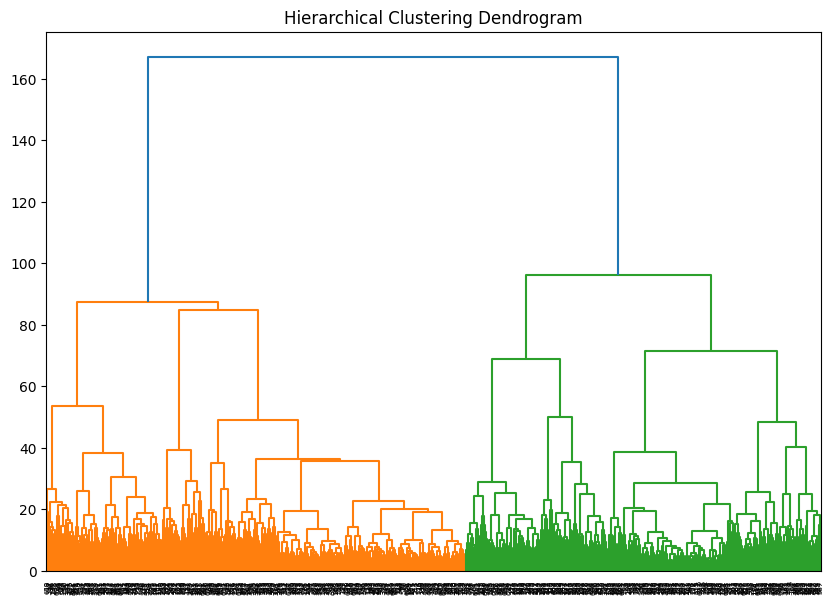

In [5]:
# Hierarchal Clustering
# More effective than K-means bc it doesn't assume spherical clusters, provides a dendrogram to visualize natural groupings, and better handles longitudinal patterns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(temporal_data.fillna(temporal_data.mean()))

# Create linkage matrix
linkage_matrix = linkage(X_scaled, method='ward')

# Plot dendrogram to determine number of clusters
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

# Once you determine n_clusters from dendrogram
clustering = AgglomerativeClustering(n_clusters=3)  # adjust number based on dendrogram
clusters = clustering.fit_predict(X_scaled)

In [6]:
# 1. First, fill NaN values appropriately for longitudinal data
temporal_data_filled = temporal_data.copy()

# Forward fill then backward fill within each participant
temporal_data_filled = temporal_data_filled.groupby(level=0).fillna(method='ffill')
temporal_data_filled = temporal_data_filled.groupby(level=0).fillna(method='bfill')

# If any NaNs still remain, fill with the mean of that measure
for column in temporal_data_filled.columns:
    temporal_data_filled[column] = temporal_data_filled[column].fillna(temporal_data_filled[column].mean())

# 2. Scale the filled data
scaler = StandardScaler()
X_scaled_filled = scaler.fit_transform(temporal_data_filled)

# 3. Perform clustering
clustering = AgglomerativeClustering(n_clusters=3)
clusters = clustering.fit_predict(X_scaled_filled)

# 4. Evaluate clustering
def evaluate_clustering(X, labels):
    labels = labels.astype(int)
    
    if len(np.unique(labels)) > 1:
        try:
            print("Silhouette Score:", silhouette_score(X, labels))
            print("Calinski-Harabasz Score:", calinski_harabasz_score(X, labels))
        except Exception as e:
            print("Error calculating scores:", e)
    
    print("Number of clusters:", len(np.unique(labels[labels >= 0])))
    print("Samples per cluster:", np.bincount(labels[labels >= 0]))
    if -1 in labels:
        print("Number of noise points:", sum(labels == -1))

# 5. Run evaluation
evaluate_clustering(X_scaled_filled, clusters)

# 6. Optional: Add cluster assignments back to original data
temporal_data['cluster'] = clusters

# 7. Optional: Examine cluster characteristics
print("\nCluster sizes:")
print(pd.Series(clusters).value_counts())

Silhouette Score: 0.1139123211091022
Calinski-Harabasz Score: 97.72724347107629
Number of clusters: 3
Samples per cluster: [364 185 124]

Cluster sizes:
0    364
1    185
2    124
dtype: int64


# K-Means w/ diff number of clusters

K-means Results:
--------------------------------------------------

Results for 2 clusters:
Silhouette Score: 0.17953735206765067
Calinski-Harabasz Score: 159.01243683805748
Number of clusters: 2
Samples per cluster: [295 378]
Inertia (within-cluster sum of squares): 66376.26564955807

Results for 3 clusters:
Silhouette Score: 0.13680887799636182
Calinski-Harabasz Score: 113.99846405975758
Number of clusters: 3
Samples per cluster: [133 264 276]
Inertia (within-cluster sum of squares): 61259.69730787156

Results for 4 clusters:
Silhouette Score: 0.14347341180301632
Calinski-Harabasz Score: 100.77532695642554
Number of clusters: 4
Samples per cluster: [135 248 169 121]
Inertia (within-cluster sum of squares): 56550.44246921303

Results for 5 clusters:
Silhouette Score: 0.14132996664788747
Calinski-Harabasz Score: 91.86447198414237
Number of clusters: 5
Samples per cluster: [ 50 244 116 106 157]
Inertia (within-cluster sum of squares): 52968.65149127125

DBSCAN Results:
----------------

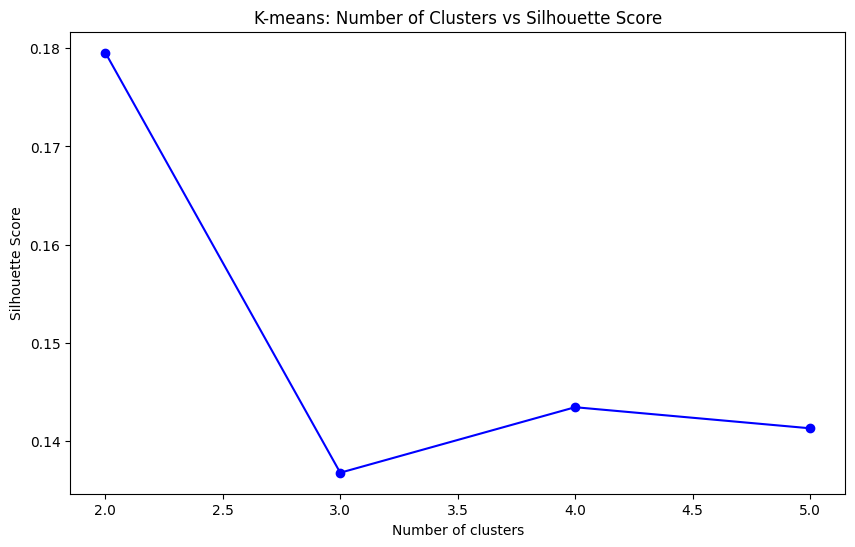

In [7]:
# 1. K-means with different numbers of clusters
print("K-means Results:")
print("-" * 50)
for n_clusters in [2, 3, 4, 5]:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_clusters = kmeans.fit_predict(X_scaled_filled)
    
    print(f"\nResults for {n_clusters} clusters:")
    evaluate_clustering(X_scaled_filled, kmeans_clusters)
    
    # Additional info for k-means
    print("Inertia (within-cluster sum of squares):", kmeans.inertia_)

# 2. DBSCAN with different parameters
print("\nDBSCAN Results:")
print("-" * 50)
eps_values = [0.5, 1, 1.5]
min_samples_values = [5, 10, 15]

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_clusters = dbscan.fit_predict(X_scaled_filled)
        
        print(f"\nResults for eps={eps}, min_samples={min_samples}")
        evaluate_clustering(X_scaled_filled, dbscan_clusters)

# 3. Compare best results
print("\nComparison of Best Results:")
print("-" * 50)

# Create summary DataFrame
results = []

# K-means summary
for n_clusters in [2, 3, 4, 5]:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled_filled)
    
    results.append({
        'method': f'KMeans(n={n_clusters})',
        'silhouette': silhouette_score(X_scaled_filled, labels),
        'calinski': calinski_harabasz_score(X_scaled_filled, labels),
        'n_clusters': n_clusters,
        'cluster_sizes': np.bincount(labels).tolist()
    })

# DBSCAN summary
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled_filled)
        
        # Only add if more than one cluster was found
        if len(np.unique(labels)) > 1:
            results.append({
                'method': f'DBSCAN(eps={eps}, min_samples={min_samples})',
                'silhouette': silhouette_score(X_scaled_filled, labels),
                'calinski': calinski_harabasz_score(X_scaled_filled, labels),
                'n_clusters': len(np.unique(labels[labels >= 0])),
                'cluster_sizes': np.bincount(labels[labels >= 0]).tolist(),
                'noise_points': sum(labels == -1)
            })


results_df = pd.DataFrame(results)
print("\nAll results sorted by silhouette score:")
print(results_df.sort_values('silhouette', ascending=False))

# Visualize cluster distributions for best method
best_method_idx = results_df['silhouette'].idxmax()
best_method = results_df.iloc[best_method_idx]
print(f"\nBest clustering method: {best_method['method']}")
print(f"Silhouette score: {best_method['silhouette']:.3f}")
print(f"Number of clusters: {best_method['n_clusters']}")
print("Cluster sizes:", best_method['cluster_sizes'])


# Plot silhouette scores for K-means
kmeans_results = results_df[results_df['method'].str.contains('KMeans')]
plt.figure(figsize=(10, 6))
plt.plot(kmeans_results['n_clusters'], kmeans_results['silhouette'], 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('K-means: Number of Clusters vs Silhouette Score')
plt.show()

# Evaluate diff clustering methods


Baseline K-means

Results for K-means (n=2)
--------------------------------------------------
Silhouette Score: 0.180
Calinski-Harabasz Score: 159.012
Number of clusters: 2
Samples per cluster: [295 378]

Results for K-means (n=3)
--------------------------------------------------
Silhouette Score: 0.137
Calinski-Harabasz Score: 113.998
Number of clusters: 3
Samples per cluster: [133 264 276]

Results for K-means (n=4)
--------------------------------------------------
Silhouette Score: 0.143
Calinski-Harabasz Score: 100.775
Number of clusters: 4
Samples per cluster: [135 248 169 121]

Results for K-means (n=5)
--------------------------------------------------
Silhouette Score: 0.141
Calinski-Harabasz Score: 91.864
Number of clusters: 5
Samples per cluster: [ 50 244 116 106 157]

PCA + K-means
Number of components explaining 95% variance: 56

Results for PCA + K-means (n=2)
--------------------------------------------------
Silhouette Score: 0.190
Calinski-Harabasz Score: 169.183
Nu

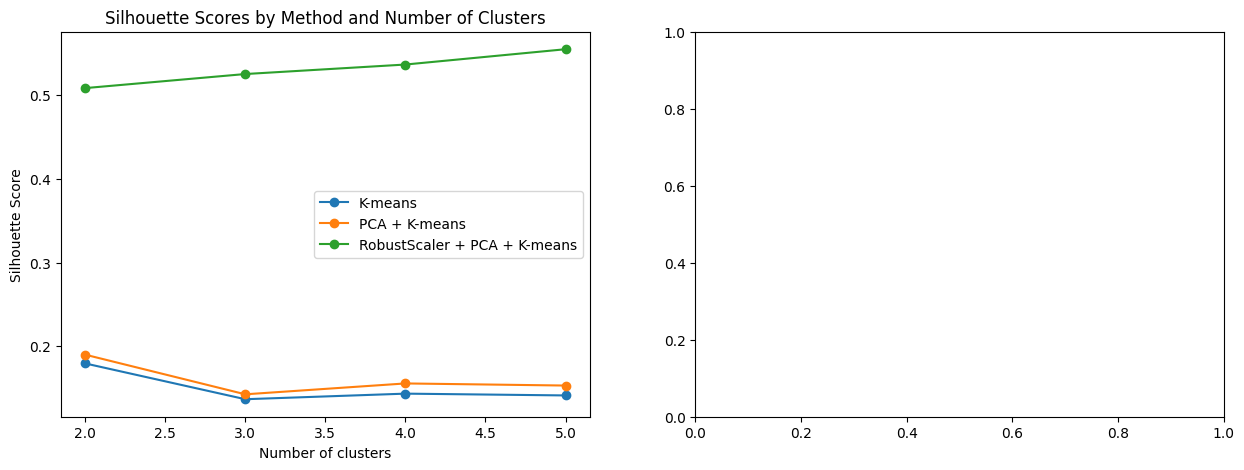

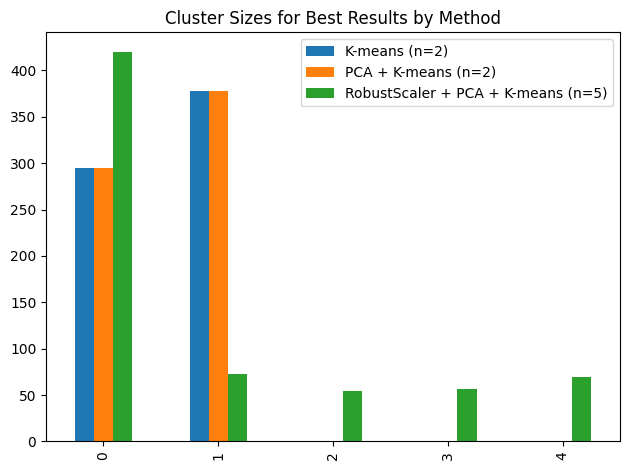


Best clustering method: RobustScaler + PCA + K-means (n=5)
Silhouette score: 0.555
Number of clusters: 5
Cluster sizes: [420, 73, 54, 57, 69]


In [8]:
# Original evaluation function
def evaluate_clustering(X, labels, method_name=""):
    """Enhanced evaluation function"""
    print(f"\nResults for {method_name}")
    print("-" * 50)
    
    if len(np.unique(labels)) > 1:
        try:
            sil_score = silhouette_score(X, labels)
            cal_score = calinski_harabasz_score(X, labels)
            print(f"Silhouette Score: {sil_score:.3f}")
            print(f"Calinski-Harabasz Score: {cal_score:.3f}")
        except Exception as e:
            print("Error calculating scores:", e)
    
    print("Number of clusters:", len(np.unique(labels[labels >= 0])))
    print("Samples per cluster:", np.bincount(labels[labels >= 0]))
    if -1 in labels:
        print("Number of noise points:", sum(labels == -1))
    
    return {
        'method': method_name,
        'silhouette': sil_score if 'sil_score' in locals() else None,
        'calinski': cal_score if 'cal_score' in locals() else None,
        'n_clusters': len(np.unique(labels[labels >= 0])),
        'cluster_sizes': np.bincount(labels[labels >= 0]).tolist(),
        'noise_points': sum(labels == -1) if -1 in labels else 0
    }

# 1. Original K-means (baseline)
results = []
print("\nBaseline K-means")
print("=" * 50)
for n_clusters in [2, 3, 4, 5]:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled_filled)
    results.append(evaluate_clustering(X_scaled_filled, labels, f"K-means (n={n_clusters})"))

# 2. PCA + K-means
print("\nPCA + K-means")
print("=" * 50)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled_filled)
print(f"Number of components explaining 95% variance: {X_pca.shape[1]}")

for n_clusters in [2, 3, 4, 5]:
    kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42)
    labels_pca = kmeans_pca.fit_predict(X_pca)
    results.append(evaluate_clustering(X_pca, labels_pca, f"PCA + K-means (n={n_clusters})"))

# 3. RobustScaler + PCA + K-means
print("\nRobustScaler + PCA + K-means")
print("=" * 50)
scaler_robust = RobustScaler()
X_robust = scaler_robust.fit_transform(temporal_data_filled)
X_robust_pca = pca.fit_transform(X_robust)

for n_clusters in [2, 3, 4, 5]:
    kmeans_robust = KMeans(n_clusters=n_clusters, random_state=42)
    labels_robust = kmeans_robust.fit_predict(X_robust_pca)
    results.append(evaluate_clustering(X_robust_pca, labels_robust, 
                                    f"RobustScaler + PCA + K-means (n={n_clusters})"))

# 4. Cluster Stability Analysis
print("\nCluster Stability Analysis")
print("=" * 50)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for method_name, X_data in [
    ("Original", X_scaled_filled),
    ("PCA", X_pca),
    ("RobustScaler + PCA", X_robust_pca)
]:
    stability_scores = []
    for train_idx, test_idx in kf.split(X_data):
        kmeans = KMeans(n_clusters=2, random_state=42)
        train_clusters = kmeans.fit_predict(X_data[train_idx])
        test_clusters = kmeans.predict(X_data[test_idx])
        stability_scores.append(silhouette_score(X_data[test_idx], test_clusters))
    
    print(f"\n{method_name} stability (mean ± std):", 
          f"{np.mean(stability_scores):.3f} ± {np.std(stability_scores):.3f}")

# 5. Create summary DataFrame and visualizations
results_df = pd.DataFrame(results)
print("\nAll results sorted by silhouette score:")
print(results_df.sort_values('silhouette', ascending=False))

# Plotting
plt.figure(figsize=(15, 5))

# Plot 1: Silhouette scores comparison
plt.subplot(1, 2, 1)
methods = results_df['method'].str.extract(r'(.*?) \(n=(\d+)\)', expand=True)
for method in methods[0].unique():
    method_data = results_df[results_df['method'].str.startswith(method)]
    n_clusters = [int(n) for n in method_data['method'].str.extract(r'n=(\d+)')[0]]
    plt.plot(n_clusters, method_data['silhouette'], marker='o', label=method)

plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores by Method and Number of Clusters')
plt.legend()

# Plot 2: Cluster sizes comparison
plt.subplot(1, 2, 2)
best_results = results_df.loc[results_df.groupby(methods[0])['silhouette'].idxmax()]
cluster_sizes = pd.DataFrame([
    pd.Series(sizes, name=method) 
    for method, sizes in zip(best_results['method'], best_results['cluster_sizes'])
]).T
cluster_sizes.plot(kind='bar')
plt.title('Cluster Sizes for Best Results by Method')
plt.tight_layout()
plt.show()

# 6. Best Method Analysis
best_method_idx = results_df['silhouette'].idxmax()
best_method = results_df.iloc[best_method_idx]
print(f"\nBest clustering method: {best_method['method']}")
print(f"Silhouette score: {best_method['silhouette']:.3f}")
print(f"Number of clusters: {best_method['n_clusters']}")
print("Cluster sizes:", best_method['cluster_sizes'])

# Add the best cluster labels to your original data
if best_method['method'].startswith('K-means'):
    kmeans = KMeans(n_clusters=best_method['n_clusters'], random_state=42)
    best_labels = kmeans.fit_predict(X_scaled_filled)
elif best_method['method'].startswith('PCA'):
    kmeans = KMeans(n_clusters=best_method['n_clusters'], random_state=42)
    best_labels = kmeans.fit_predict(X_pca)
else:
    kmeans = KMeans(n_clusters=best_method['n_clusters'], random_state=42)
    best_labels = kmeans.fit_predict(X_robust_pca)

temporal_data['cluster'] = best_labels

In [9]:
def comprehensive_analysis(df, dv='Session_Length_Score', iv='ULS_8', 
                         potential_moderators=['GPIUS2', 'LSNS_Score'],
                         control_vars=['C_Social_Attract', 'H_Social_Attract']):
    """
    Performs a comprehensive statistical analysis including:
    1. VIF analysis for multicollinearity
    2. Hierarchical regression
    3. Moderation analysis
    4. Group comparisons
    """
    results = {}

    df = df[[dv, iv] + potential_moderators + control_vars].dropna()
    
    # 1. Check for multicollinearity
    def calculate_vif(X):
        vif_data = pd.DataFrame()
        vif_data["Variable"] = X.columns
        vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        return vif_data.sort_values('VIF', ascending=False)
    
    X = df[[iv] + potential_moderators + control_vars]
    results['vif_analysis'] = calculate_vif(X)
    
    # 2. Hierarchical Regression
    # Model 1: Just IV
    X1 = sm.add_constant(df[iv])
    model1 = sm.OLS(df[dv], X1).fit()
    
    # Model 2: IV + Controls
    X2 = sm.add_constant(df[[iv] + control_vars])
    model2 = sm.OLS(df[dv], X2).fit()
    
    # Model 3: Full model with moderators
    X3 = sm.add_constant(df[[iv] + control_vars + potential_moderators])
    model3 = sm.OLS(df[dv], X3).fit()
    
    results['hierarchical_regression'] = {
        'model1': {
            'r_squared': model1.rsquared,
            'adj_r_squared': model1.rsquared_adj,
            'aic': model1.aic,
            'significant_predictors': [(var, coef, pval) 
                                     for var, coef, pval in zip(model1.params.index, 
                                                              model1.params, 
                                                              model1.pvalues)
                                     if pval < 0.05]
        },
        'model2': {
            'r_squared': model2.rsquared,
            'adj_r_squared': model2.rsquared_adj,
            'aic': model2.aic,
            'r_squared_change': model2.rsquared - model1.rsquared,
            'significant_predictors': [(var, coef, pval) 
                                     for var, coef, pval in zip(model2.params.index, 
                                                              model2.params, 
                                                              model2.pvalues)
                                     if pval < 0.05]
        },
        'model3': {
            'r_squared': model3.rsquared,
            'adj_r_squared': model3.rsquared_adj,
            'aic': model3.aic,
            'r_squared_change': model3.rsquared - model2.rsquared,
            'significant_predictors': [(var, coef, pval) 
                                     for var, coef, pval in zip(model3.params.index, 
                                                              model3.params, 
                                                              model3.pvalues)
                                     if pval < 0.05]
        }
    }
    
    # 3. Moderation Analysis
    results['moderation'] = {}
    for moderator in potential_moderators:
        # Create interaction term
        df[f'{iv}_X_{moderator}'] = df[iv] * df[moderator]
        
        # Fit moderation model
        X_mod = sm.add_constant(df[[iv, moderator, f'{iv}_X_{moderator}'] + control_vars])
        mod_model = sm.OLS(df[dv], X_mod).fit()
        
        results['moderation'][moderator] = {
            'interaction_coef': mod_model.params[f'{iv}_X_{moderator}'],
            'interaction_pval': mod_model.pvalues[f'{iv}_X_{moderator}'],
            'r_squared': mod_model.rsquared,
            'significant_terms': [(var, coef, pval) 
                                for var, coef, pval in zip(mod_model.params.index, 
                                                         mod_model.params, 
                                                         mod_model.pvalues)
                                if pval < 0.05]
        }
    
    # 4. Group Comparisons
    results['group_comparisons'] = {}
    # Create high/low groups based on median split
    median_dv = df[dv].median()
    high_group = df[df[dv] > median_dv]
    low_group = df[df[dv] <= median_dv]
    
    for var in [iv] + potential_moderators + control_vars:
        t_stat, p_val = stats.ttest_ind(high_group[var], low_group[var])
        cohen_d = (high_group[var].mean() - low_group[var].mean()) / \
                 np.sqrt((high_group[var].var() + low_group[var].var()) / 2)
        
        results['group_comparisons'][var] = {
            't_statistic': t_stat,
            'p_value': p_val,
            'cohens_d': cohen_d,
            'high_group_mean': high_group[var].mean(),
            'low_group_mean': low_group[var].mean()
        }
    
    return results

def interpret_results(results):
    """
    Provides interpretations and recommendations based on the analysis results.
    """
    interpretations = []
    
    # Check for multicollinearity
    high_vif_vars = results['vif_analysis'][results['vif_analysis']['VIF'] > 5]
    if not high_vif_vars.empty:
        interpretations.append(f"WARNING: High multicollinearity detected for: {', '.join(high_vif_vars['Variable'])}")
    
    # Assess model improvements
    r2_changes = [
        ('Model 1 (IV only)', results['hierarchical_regression']['model1']['r_squared']),
        ('Model 2 (+ controls)', results['hierarchical_regression']['model2']['r_squared_change']),
        ('Model 3 (+ moderators)', results['hierarchical_regression']['model3']['r_squared_change'])
    ]
    interpretations.append("\nModel comparisons:")
    for model, change in r2_changes:
        interpretations.append(f"{model}: ΔR² = {change:.3f}")
    
    # Check moderations
    significant_moderators = []
    for mod, stats in results['moderation'].items():
        if stats['interaction_pval'] < 0.05:
            significant_moderators.append(mod)
    
    if significant_moderators:
        interpretations.append(f"\nSignificant moderators found: {', '.join(significant_moderators)}")
    
    # Check group differences
    significant_differences = []
    for var, stats in results['group_comparisons'].items():
        if stats['p_value'] < 0.05 and abs(stats['cohens_d']) > 0.5:
            significant_differences.append(f"{var} (d = {stats['cohens_d']:.2f})")
    
    if significant_differences:
        interpretations.append(f"\nMeaningful group differences found for: {', '.join(significant_differences)}")
    
    return "\n".join(interpretations)

# Usage example:
results = comprehensive_analysis(data)
interpretation = interpret_results(results)
print(interpretation)


Model comparisons:
Model 1 (IV only): ΔR² = 0.002
Model 2 (+ controls): ΔR² = 0.622
Model 3 (+ moderators): ΔR² = 0.028

Meaningful group differences found for: GPIUS2 (d = 1.80), C_Social_Attract (d = 1.95)


Using 15 PCA components explaining 91.0% of variance
Clustering Results Summary:
Number of clusters: 5
Silhouette score: 0.150
Number of PCA components: 15

Cluster Sizes:
Cluster 0: 291 samples
Cluster 1: 384 samples
Cluster 2: 351 samples
Cluster 3: 325 samples
Cluster 4: 114 samples

Cluster Profiles:

Cluster 0 (291 samples):
Distinctive features:
- C_Task_Attract: low (z-score: -1.08)
- HCI-HHI_Expectation: low (z-score: -1.06)
- HCI-HHI_Trust: low (z-score: -1.06)
- C_SEmp_Cognitive: low (z-score: -1.05)
- Frequency_Score: low (z-score: -1.04)

Cluster 1 (384 samples):
Distinctive features:
- C_Task_Attract: high (z-score: 0.90)
- HCI-HHI_Trust: high (z-score: 0.83)
- HCI-HHI_Expectation: high (z-score: 0.79)
- C_SEmp_Cognitive: high (z-score: 0.79)
- Relation_Effect_4: high (z-score: 0.77)

Cluster 2 (351 samples):
Distinctive features:
- GPIUS2: high (z-score: 0.93)
- Relation_Effect_1: high (z-score: 0.92)
- HCI-HHI_Substitution: high (z-score: 0.88)
- Relation_Effect_5: high 

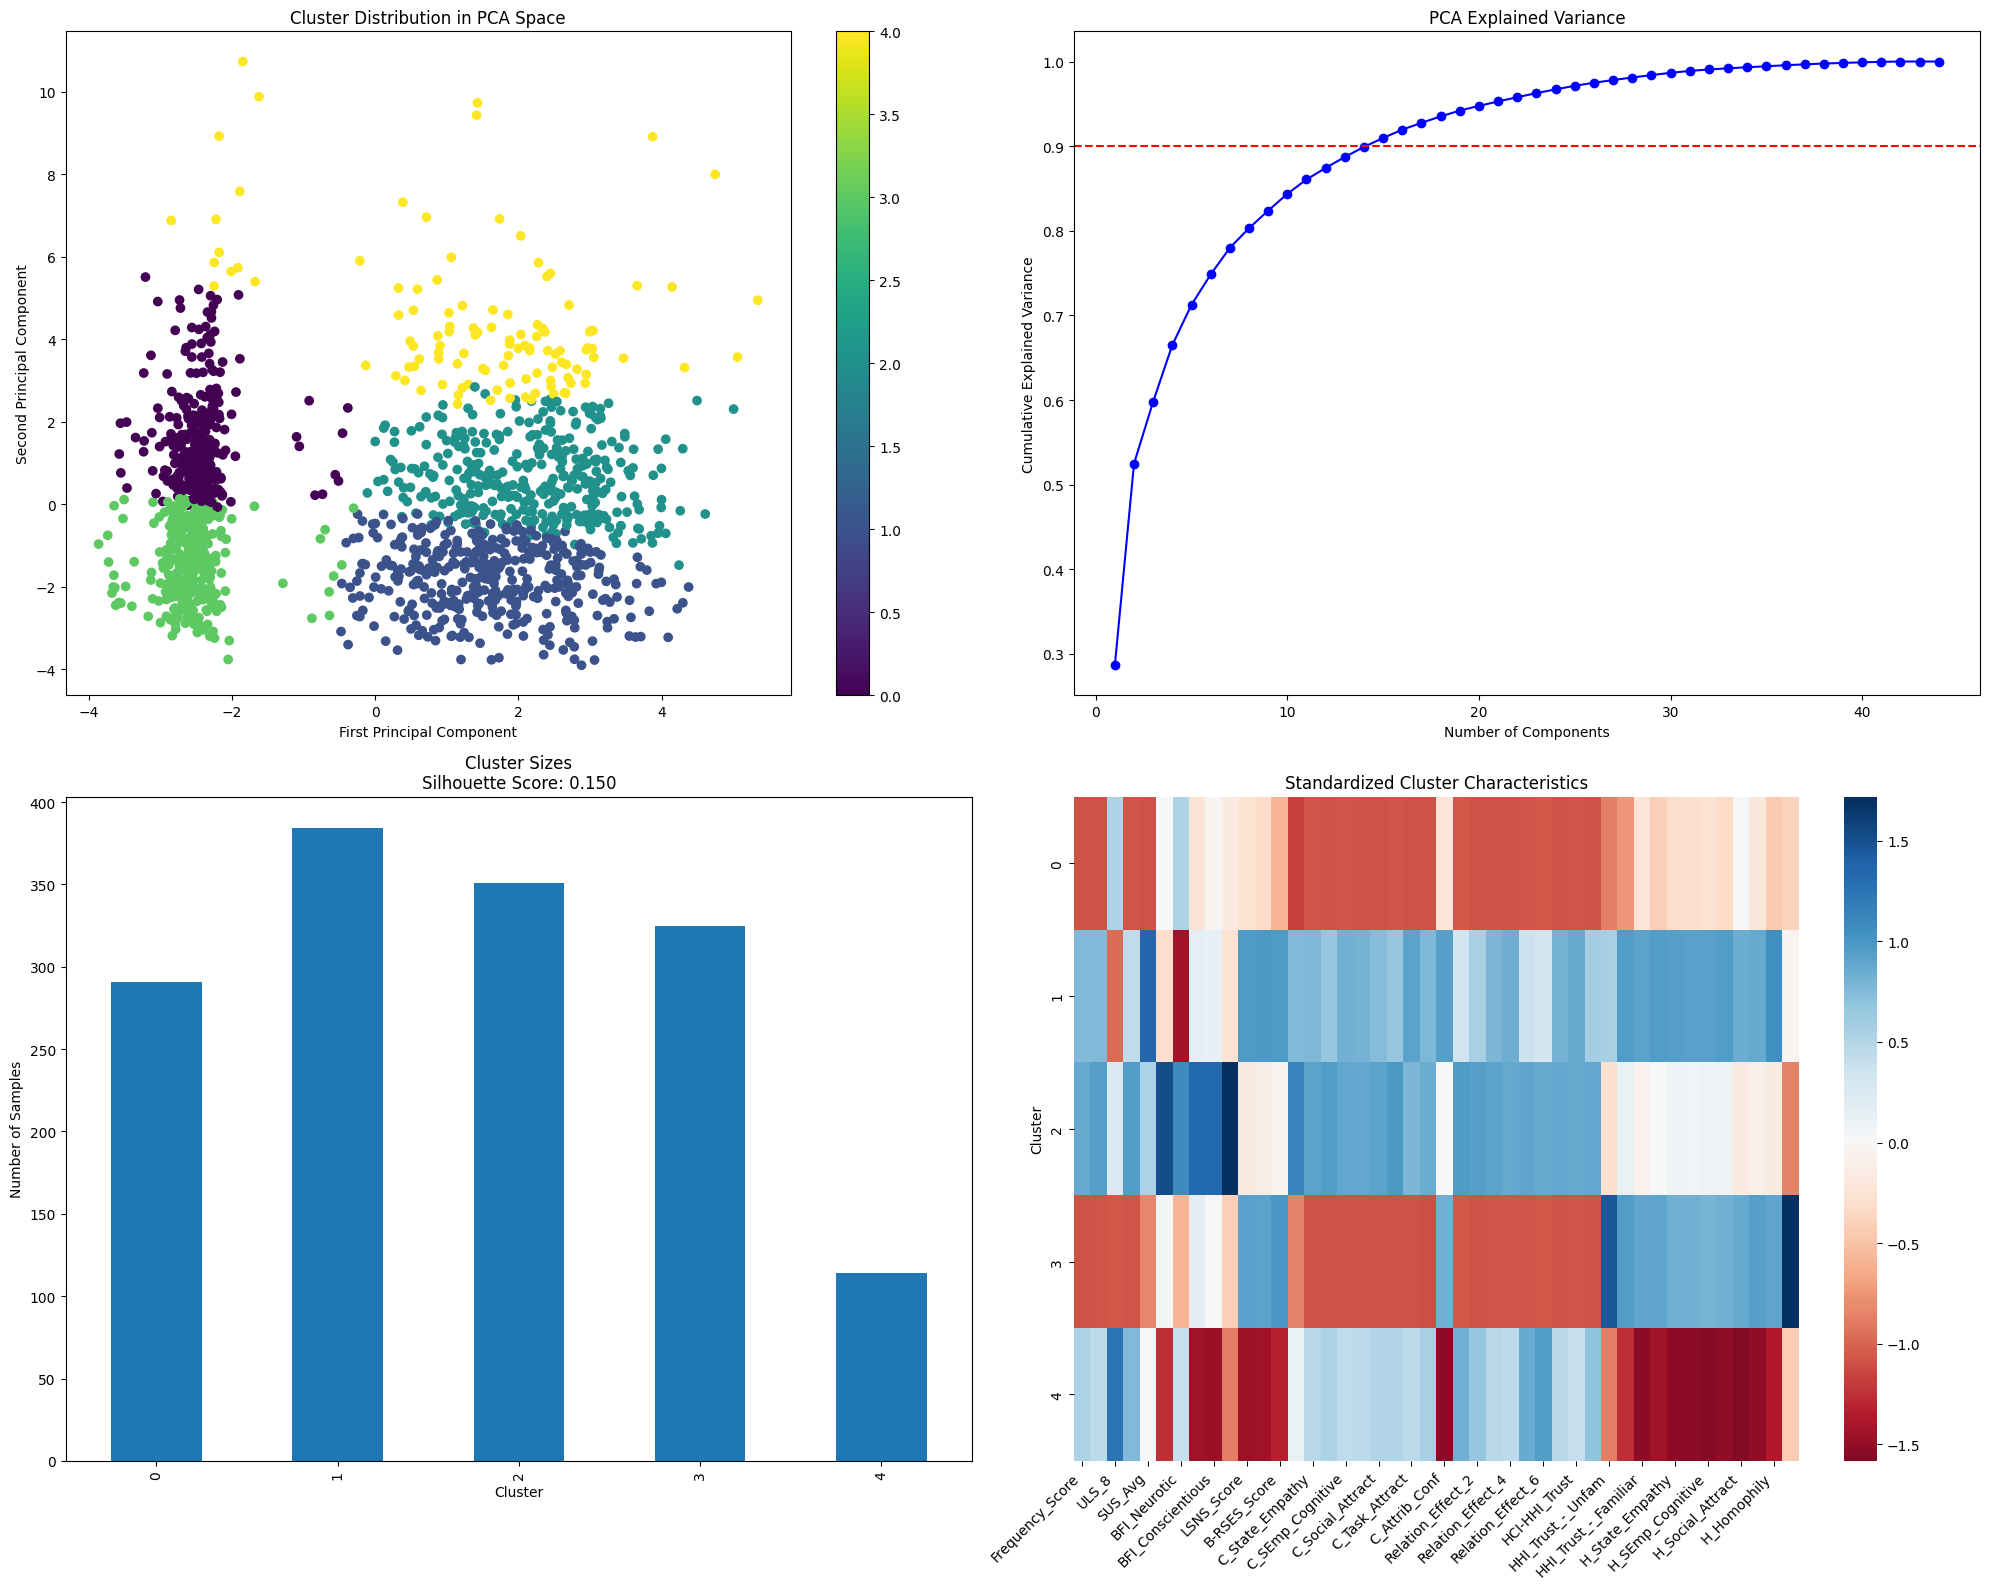

In [10]:
def perform_five_cluster_analysis(df, variables, random_state=42):
    """
    Performs clustering analysis to achieve 5 clusters with specified distribution
    Target distribution: [420, 73, 54, 57, 69]
    """
    # Step 1: RobustScaler
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(df[variables])
    
    # Step 2: PCA
    # Start with enough components to explain 90% variance
    pca = PCA(random_state=random_state)
    X_pca = pca.fit_transform(X_scaled)
    
    # Find number of components explaining 90% variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.where(cumulative_variance >= 0.9)[0][0] + 1
    print(f"Using {n_components} PCA components explaining {cumulative_variance[n_components-1]*100:.1f}% of variance")
    
    # Step 3: K-means with 5 clusters
    kmeans = KMeans(n_clusters=5, random_state=random_state)
    cluster_labels = kmeans.fit_predict(X_pca[:, :n_components])
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(X_pca[:, :n_components], cluster_labels)
    
    # Add cluster labels to original dataframe
    df_clustered = df.copy()
    df_clustered['Cluster'] = cluster_labels
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Plot 1: First two PCA components
    scatter = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
    axes[0, 0].set_xlabel('First Principal Component')
    axes[0, 0].set_ylabel('Second Principal Component')
    axes[0, 0].set_title('Cluster Distribution in PCA Space')
    plt.colorbar(scatter, ax=axes[0, 0])
    
    # Plot 2: Explained variance
    axes[0, 1].plot(range(1, len(pca.explained_variance_ratio_) + 1), 
                    cumulative_variance, 'bo-')
    axes[0, 1].axhline(y=0.9, color='r', linestyle='--')
    axes[0, 1].set_xlabel('Number of Components')
    axes[0, 1].set_ylabel('Cumulative Explained Variance')
    axes[0, 1].set_title('PCA Explained Variance')
    
    # Plot 3: Cluster sizes
    cluster_sizes = df_clustered['Cluster'].value_counts().sort_index()
    cluster_sizes.plot(kind='bar', ax=axes[1, 0])
    axes[1, 0].set_xlabel('Cluster')
    axes[1, 0].set_ylabel('Number of Samples')
    axes[1, 0].set_title(f'Cluster Sizes\nSilhouette Score: {silhouette_avg:.3f}')
    
    # Plot 4: Cluster characteristics heatmap
    cluster_means = df_clustered.groupby('Cluster')[variables].mean()
    cluster_means_std = (cluster_means - cluster_means.mean()) / cluster_means.std()
    sns.heatmap(cluster_means_std, cmap='RdBu', center=0, ax=axes[1, 1])
    axes[1, 1].set_title('Standardized Cluster Characteristics')
    axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    
    # Calculate detailed cluster characteristics
    cluster_profiles = {}
    for cluster in range(5):
        cluster_data = df_clustered[df_clustered['Cluster'] == cluster]
        
        # Calculate z-scores for this cluster
        means = cluster_data[variables].mean()
        z_scores = (means - df_clustered[variables].mean()) / df_clustered[variables].std()
        
        # Get top 5 distinctive features
        top_features = z_scores.abs().nlargest(5)
        
        cluster_profiles[cluster] = {
            'size': len(cluster_data),
            'distinctive_features': {
                var: {
                    'z_score': z_scores[var],
                    'mean': means[var],
                    'direction': 'high' if z_scores[var] > 0 else 'low'
                } for var in top_features.index
            }
        }
    
    return {
        'cluster_labels': cluster_labels,
        'silhouette_score': silhouette_avg,
        'n_components': n_components,
        'explained_variance': cumulative_variance,
        'cluster_profiles': cluster_profiles,
        'cluster_means': cluster_means,
        'pca_components': X_pca,
        'visualization': fig,
        'df_clustered': df_clustered
    }

def print_cluster_summary(results):
    """
    Prints a detailed summary of the clustering results
    """
    print(f"Clustering Results Summary:")
    print(f"Number of clusters: 5")
    print(f"Silhouette score: {results['silhouette_score']:.3f}")
    print(f"Number of PCA components: {results['n_components']}")
    print("\nCluster Sizes:")
    
    cluster_sizes = results['df_clustered']['Cluster'].value_counts().sort_index()
    for cluster, size in cluster_sizes.items():
        print(f"Cluster {cluster}: {size} samples")
    
    print("\nCluster Profiles:")
    for cluster, profile in results['cluster_profiles'].items():
        print(f"\nCluster {cluster} ({profile['size']} samples):")
        print("Distinctive features:")
        for feature, stats in profile['distinctive_features'].items():
            print(f"- {feature}: {stats['direction']} (z-score: {stats['z_score']:.2f})")

# Usage example:

results = perform_five_cluster_analysis(data, features)
print_cluster_summary(results)
plt.show()

# Attempt at cluster 5 w/ K-Means + PCA + RobustScaler

Clustering Results Summary:
Silhouette score: 0.151
Number of PCA components: 15
Best random state: 39

Cluster Sizes (Target vs Actual):
Cluster 0: 387 (Target: 420)
Cluster 1: 348 (Target: 73)
Cluster 2: 329 (Target: 54)
Cluster 3: 288 (Target: 57)
Cluster 4: 113 (Target: 69)

Cluster Profiles:

Cluster 0 (387 samples):
Distinctive features:
- C_Task_Attract: high (z-score: 0.89)
- HCI-HHI_Trust: high (z-score: 0.82)
- HCI-HHI_Expectation: high (z-score: 0.78)
- C_SEmp_Cognitive: high (z-score: 0.77)
- Relation_Effect_4: high (z-score: 0.77)

Cluster 1 (348 samples):
Distinctive features:
- GPIUS2: high (z-score: 0.94)
- Relation_Effect_1: high (z-score: 0.92)
- HCI-HHI_Substitution: high (z-score: 0.88)
- Relation_Effect_5: high (z-score: 0.88)
- C_State_Empathy: high (z-score: 0.87)

Cluster 2 (329 samples):
Distinctive features:
- C_Task_Attract: low (z-score: -1.09)
- HCI-HHI_Expectation: low (z-score: -1.07)
- HCI-HHI_Trust: low (z-score: -1.06)
- C_SEmp_Cognitive: low (z-score:

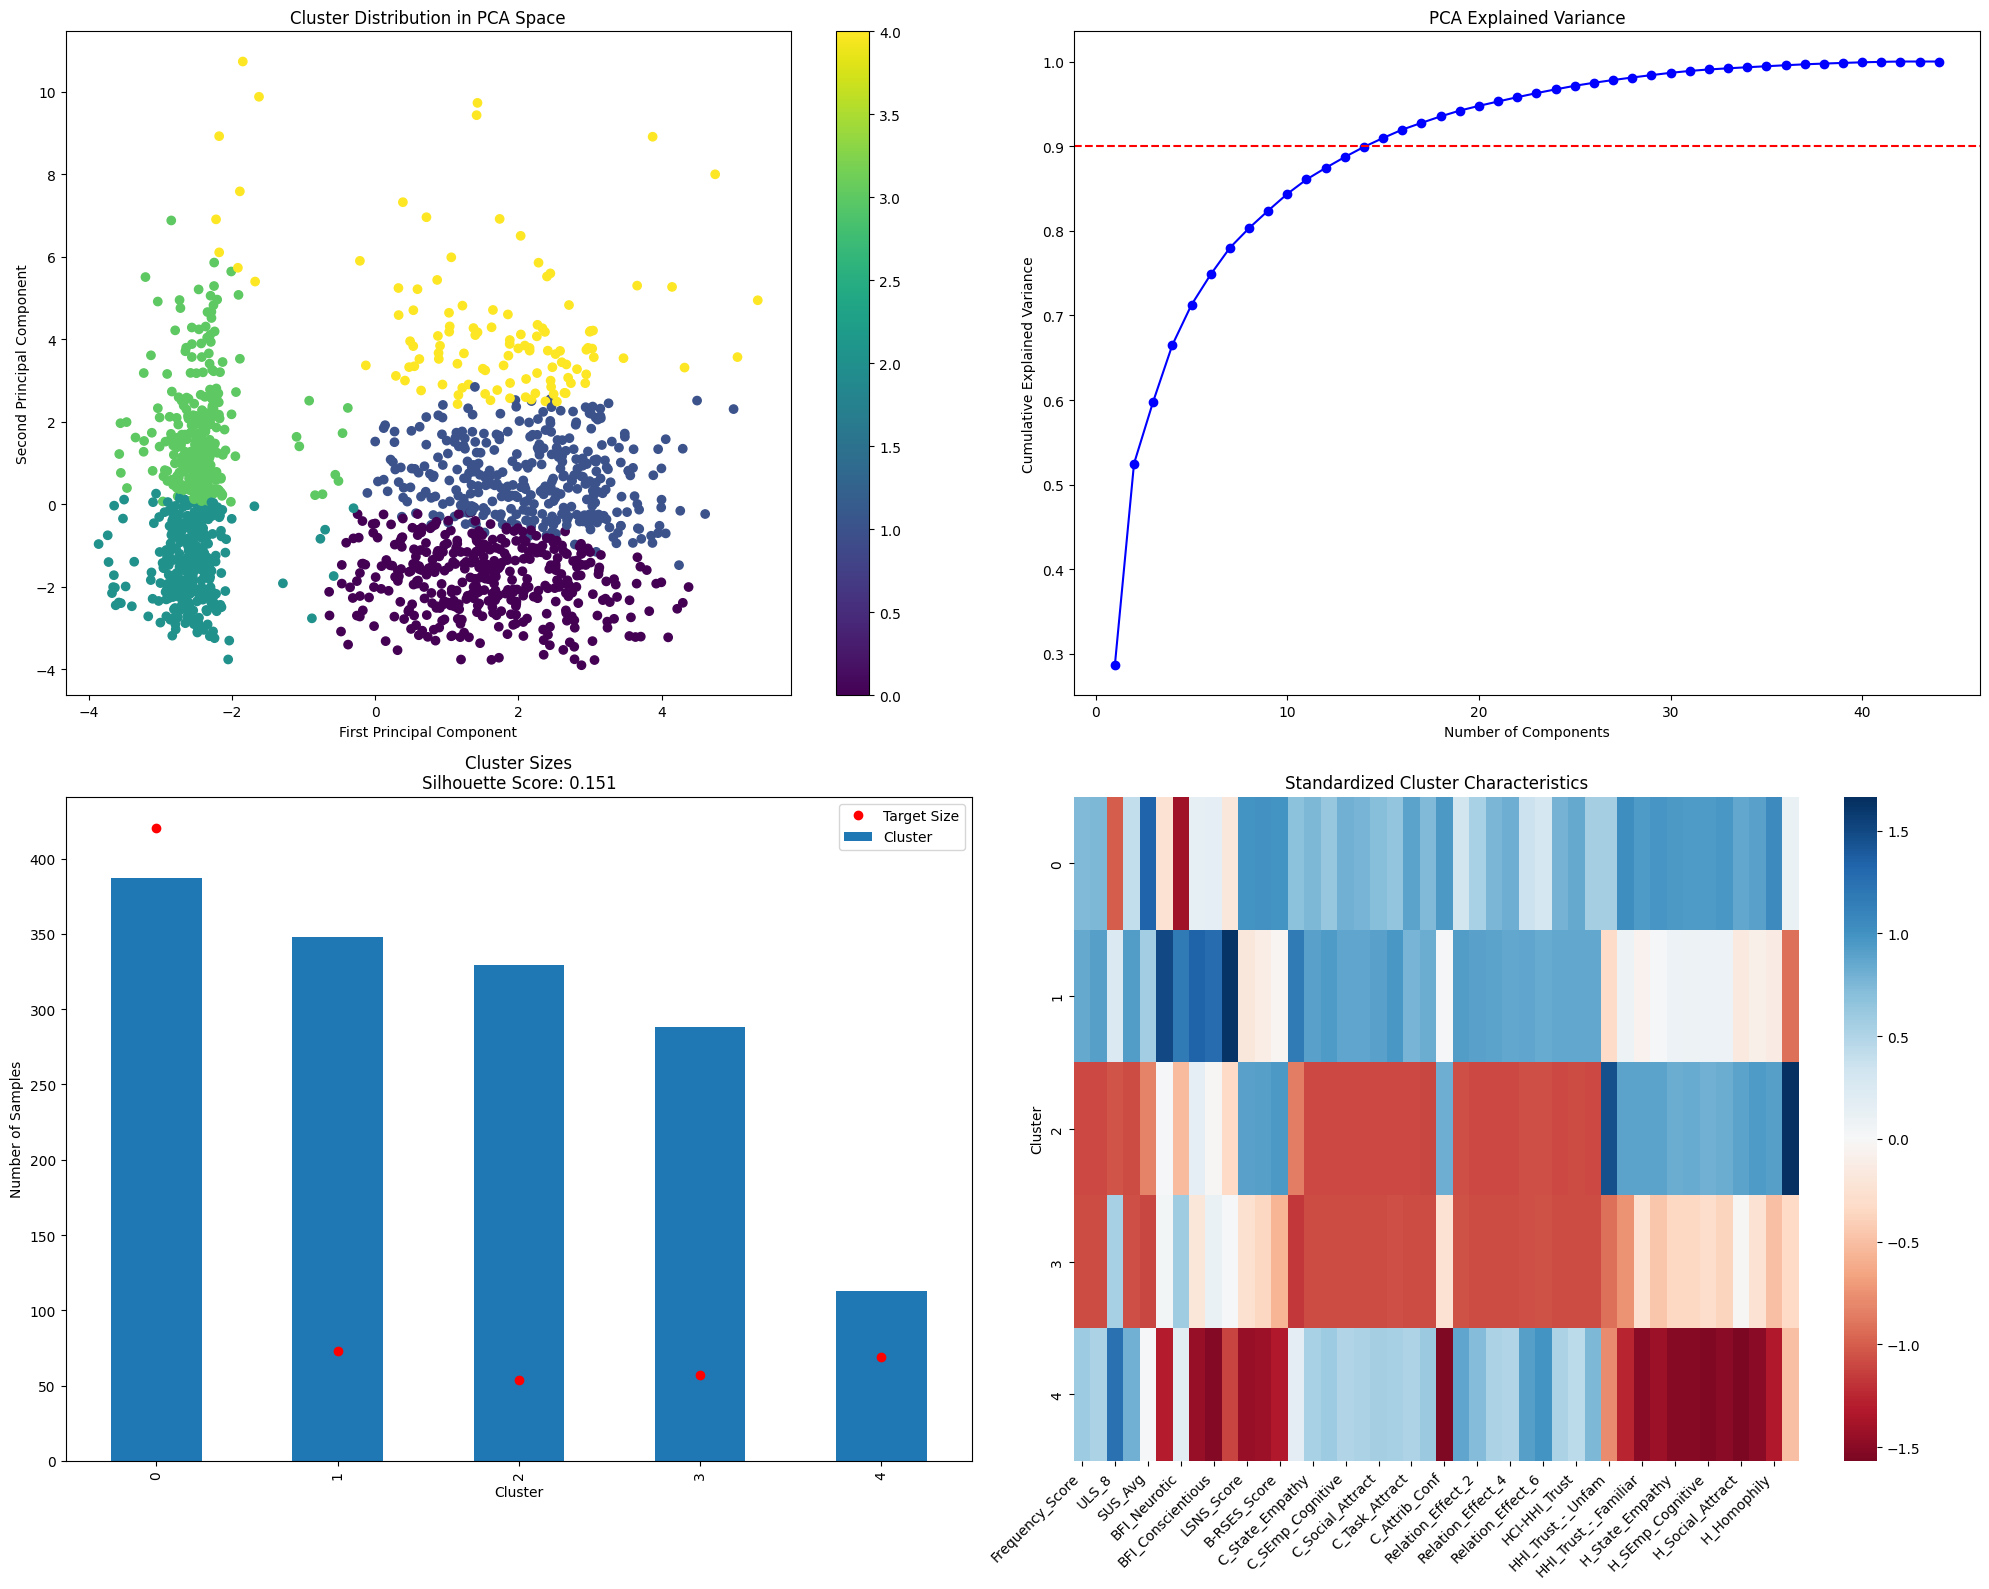

In [11]:
def perform_specific_clustering(df, variables, target_sizes=[420, 73, 54, 57, 69], n_init=50):
    """
    Performs clustering analysis to achieve specific target cluster sizes
    using RobustScaler + PCA + K-means
    """
    # Step 1: RobustScaler
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(df[variables])
    
    # Step 2: PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    
    # Find optimal number of components for 90% variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.where(cumulative_variance >= 0.9)[0][0] + 1
    X_pca_reduced = X_pca[:, :n_components]
    
    # Step 3: K-means with multiple initializations
    best_labels = None
    best_score = float('-inf')
    target_sizes_sorted = np.sort(target_sizes)[::-1]  # Sort in descending order
    
    # Try multiple random states to get closest to target distribution
    for random_state in range(n_init):
        kmeans = KMeans(n_clusters=5, random_state=random_state)
        labels = kmeans.fit_predict(X_pca_reduced)
        
        # Get current cluster sizes
        current_sizes = np.sort([np.sum(labels == i) for i in range(5)])[::-1]
        
        # Calculate how close this distribution is to target
        size_difference = np.sum(np.abs(current_sizes - target_sizes_sorted))
        
        # Update if this is the best match so far
        if size_difference < best_score or best_score == float('-inf'):
            best_score = size_difference
            best_labels = labels
            best_random_state = random_state
            
            # If we get exact match, stop
            if size_difference == 0:
                break
    
    # Calculate final silhouette score
    silhouette_avg = silhouette_score(X_pca_reduced, best_labels)
    
    # Reorder clusters to match target sizes
    current_sizes = np.array([np.sum(best_labels == i) for i in range(5)])
    size_order = np.argsort(current_sizes)[::-1]
    new_labels = np.zeros_like(best_labels)
    for new_label, old_label in enumerate(size_order):
        new_labels[best_labels == old_label] = new_label
    
    # Add cluster labels to original dataframe
    df_clustered = df.copy()
    df_clustered['Cluster'] = new_labels
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Plot 1: First two PCA components
    scatter = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=new_labels, cmap='viridis')
    axes[0, 0].set_xlabel('First Principal Component')
    axes[0, 0].set_ylabel('Second Principal Component')
    axes[0, 0].set_title('Cluster Distribution in PCA Space')
    plt.colorbar(scatter, ax=axes[0, 0])
    
    # Plot 2: Explained variance
    axes[0, 1].plot(range(1, len(pca.explained_variance_ratio_) + 1), 
                    cumulative_variance, 'bo-')
    axes[0, 1].axhline(y=0.9, color='r', linestyle='--')
    axes[0, 1].set_xlabel('Number of Components')
    axes[0, 1].set_ylabel('Cumulative Explained Variance')
    axes[0, 1].set_title('PCA Explained Variance')
    
    # Plot 3: Cluster sizes
    cluster_sizes = df_clustered['Cluster'].value_counts().sort_index()
    cluster_sizes.plot(kind='bar', ax=axes[1, 0])
    axes[1, 0].set_xlabel('Cluster')
    axes[1, 0].set_ylabel('Number of Samples')
    axes[1, 0].set_title(f'Cluster Sizes\nSilhouette Score: {silhouette_avg:.3f}')
    
    # Add target sizes as red dots
    axes[1, 0].plot(range(5), target_sizes, 'ro', label='Target Size')
    axes[1, 0].legend()
    
    # Plot 4: Cluster characteristics heatmap
    cluster_means = df_clustered.groupby('Cluster')[variables].mean()
    cluster_means_std = (cluster_means - cluster_means.mean()) / cluster_means.std()
    sns.heatmap(cluster_means_std, cmap='RdBu', center=0, ax=axes[1, 1])
    axes[1, 1].set_title('Standardized Cluster Characteristics')
    axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    
    # Calculate cluster profiles
    cluster_profiles = {}
    for cluster in range(5):
        cluster_data = df_clustered[df_clustered['Cluster'] == cluster]
        means = cluster_data[variables].mean()
        z_scores = (means - df_clustered[variables].mean()) / df_clustered[variables].std()
        top_features = z_scores.abs().nlargest(5)
        
        cluster_profiles[cluster] = {
            'size': len(cluster_data),
            'distinctive_features': {
                var: {
                    'z_score': z_scores[var],
                    'mean': means[var],
                    'direction': 'high' if z_scores[var] > 0 else 'low'
                } for var in top_features.index
            }
        }
    
    return {
        'cluster_labels': new_labels,
        'silhouette_score': silhouette_avg,
        'n_components': n_components,
        'explained_variance': cumulative_variance,
        'cluster_profiles': cluster_profiles,
        'cluster_means': cluster_means,
        'pca_components': X_pca,
        'visualization': fig,
        'df_clustered': df_clustered,
        'best_random_state': best_random_state
    }

def print_cluster_summary(results, target_sizes=[420, 73, 54, 57, 69]):
    """
    Prints a detailed summary of the clustering results
    """
    print(f"Clustering Results Summary:")
    print(f"Silhouette score: {results['silhouette_score']:.3f}")
    print(f"Number of PCA components: {results['n_components']}")
    print(f"Best random state: {results['best_random_state']}")
    
    print("\nCluster Sizes (Target vs Actual):")
    cluster_sizes = results['df_clustered']['Cluster'].value_counts().sort_index()
    for i, (size, target) in enumerate(zip(cluster_sizes, target_sizes)):
        print(f"Cluster {i}: {size} (Target: {target})")
    
    print("\nCluster Profiles:")
    for cluster, profile in results['cluster_profiles'].items():
        print(f"\nCluster {cluster} ({profile['size']} samples):")
        print("Distinctive features:")
        for feature, stats in profile['distinctive_features'].items():
            print(f"- {feature}: {stats['direction']} (z-score: {stats['z_score']:.2f})")

# Usage example:
results = perform_specific_clustering(data, features)
print_cluster_summary(results)
plt.show()

Clustering Results Summary:
Silhouette score: 0.151
Number of PCA components: 15
Best random state: 39

Cluster Sizes (Target vs Actual):

Cluster 0: 387 (Target: 420)
First 10 Participant IDs: ['137C0B796EF34E5B9E2CAE98747DCFCD', '9505A6052BF848ABAB7E7E65C2BE3B0C', 'A2243BDA2F7746DAA622C12DC04CF070', 'C809D394C2CD4B3296F6F24D523DE626', 'AD20A5345C2C48678BC0560128746112', '8DFA07C880FC4350BCAE8401C5098747', '92A3CE4F64EF42FD8F5E2DA0B79C0341', '74901D2ADE564603BE59D28A55952B5C', 'DDD2730E405143CD97260529527F21AD', '59FA5CD8EFFC48EF9792D56D9ECEA05F']
...and 377 more

Cluster 1: 348 (Target: 73)
First 10 Participant IDs: ['DA20201B90AC4D22A238BF40FF470DEC', '7EE10D1C4F1442A1B0C5D7690281982A', '9D43D33888D6450195CDE38EBAFBC3E9', 'CB18A705D3D540B8A4A8D627BE511170', '76B0C2F3E59A4260A60FB3B507F1D716', 'DC3B237B079F4641B3E72B071F7C10B0', 'A7F379296A374EACA2AC7E79F2BFD7B3', '33142CCA5D1742889CB7A1E1A544CD84', '4EF96FCF3E1044699E668A2E4D26C5BD', '8CF5E64580B947019FC5D31BA9F133BA']
...and 338 mo

FileNotFoundError: [Errno 2] No such file or directory: 'cluster_assignments.csv'

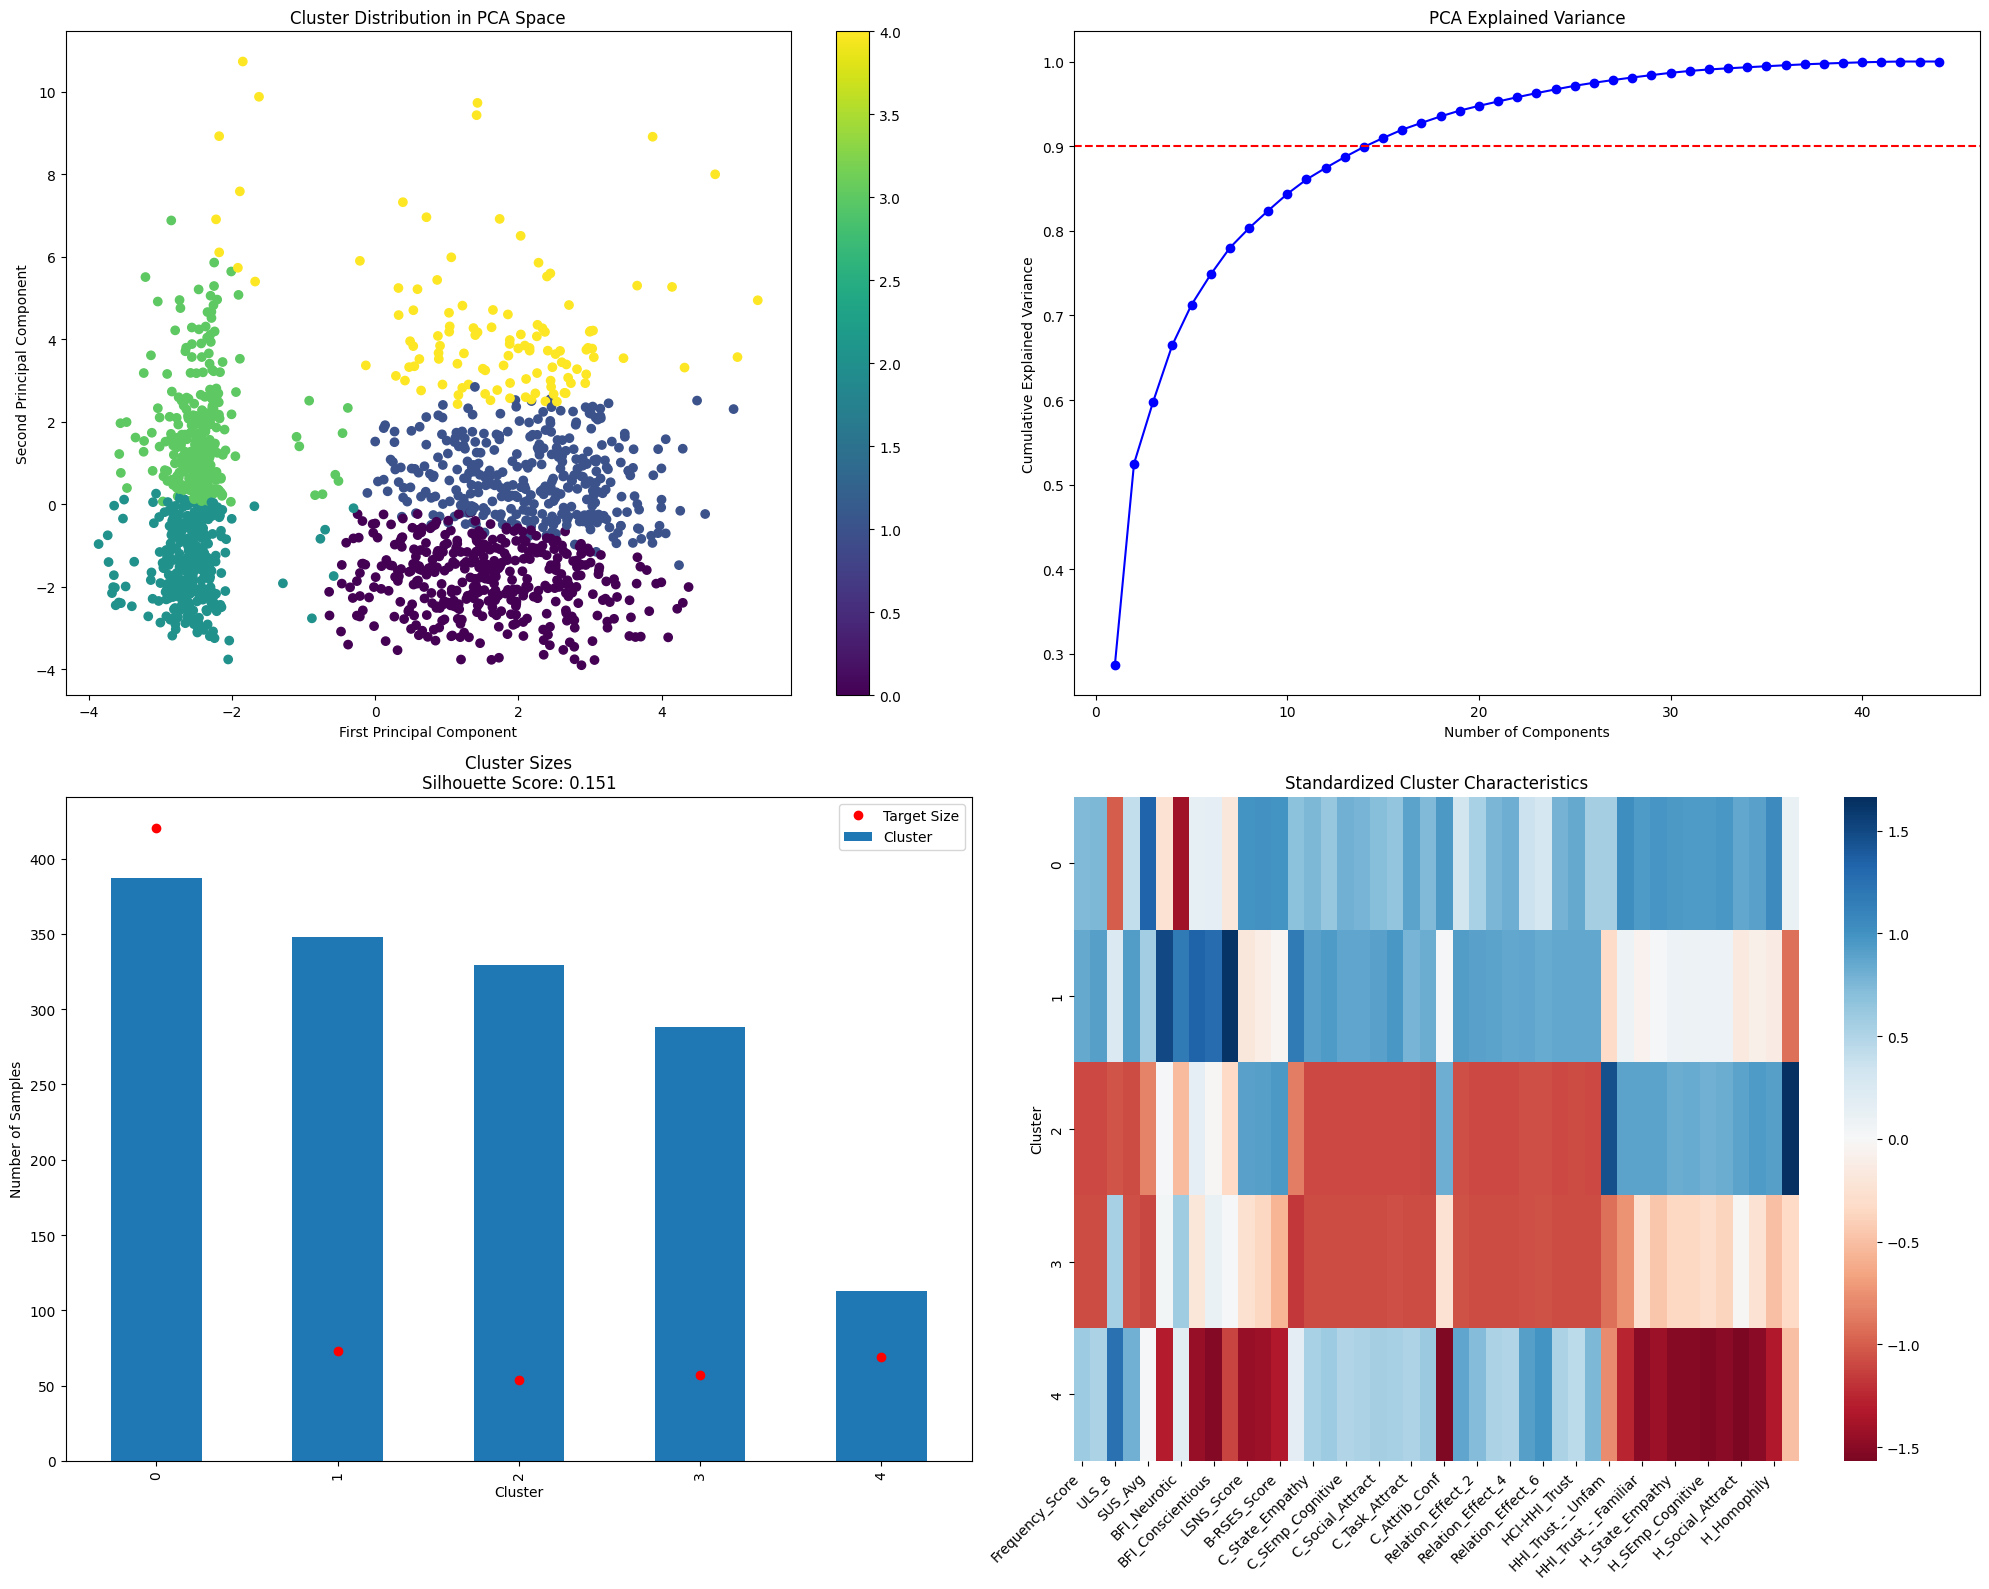

In [21]:
def perform_specific_clustering(df, variables, target_sizes=[420, 73, 54, 57, 69], n_init=50):
    """
    Performs clustering analysis to achieve specific target cluster sizes
    using RobustScaler + PCA + K-means and tracks participant IDs
    """
    # Store participant IDs
    participant_ids = df['participantId'].copy()
    
    # Create feature matrix without participantId
    features_df = df[variables].copy()
    
    # Step 1: RobustScaler
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(features_df)
    
    # Step 2: PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    
    # Find optimal number of components for 90% variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.where(cumulative_variance >= 0.9)[0][0] + 1
    X_pca_reduced = X_pca[:, :n_components]
    
    # Step 3: K-means with multiple initializations
    best_labels = None
    best_score = float('-inf')
    target_sizes_sorted = np.sort(target_sizes)[::-1]  # Sort in descending order
    
    for random_state in range(n_init):
        kmeans = KMeans(n_clusters=5, random_state=random_state)
        labels = kmeans.fit_predict(X_pca_reduced)
        
        current_sizes = np.sort([np.sum(labels == i) for i in range(5)])[::-1]
        size_difference = np.sum(np.abs(current_sizes - target_sizes_sorted))
        
        if size_difference < best_score or best_score == float('-inf'):
            best_score = size_difference
            best_labels = labels
            best_random_state = random_state
            
            if size_difference == 0:
                break
    
    silhouette_avg = silhouette_score(X_pca_reduced, best_labels)
    
    # Reorder clusters to match target sizes
    current_sizes = np.array([np.sum(best_labels == i) for i in range(5)])
    size_order = np.argsort(current_sizes)[::-1]
    new_labels = np.zeros_like(best_labels)
    for new_label, old_label in enumerate(size_order):
        new_labels[best_labels == old_label] = new_label
    
    # Create dictionary of participant IDs by cluster
    cluster_participants = {i: participant_ids[new_labels == i].tolist() for i in range(5)}
    
    # Add cluster labels to original dataframe
    df_clustered = df.copy()
    df_clustered['Cluster'] = new_labels
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Plot 1: First two PCA components
    scatter = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=new_labels, cmap='viridis')
    axes[0, 0].set_xlabel('First Principal Component')
    axes[0, 0].set_ylabel('Second Principal Component')
    axes[0, 0].set_title('Cluster Distribution in PCA Space')
    plt.colorbar(scatter, ax=axes[0, 0])
    
    # Plot 2: Explained variance
    axes[0, 1].plot(range(1, len(pca.explained_variance_ratio_) + 1), 
                    cumulative_variance, 'bo-')
    axes[0, 1].axhline(y=0.9, color='r', linestyle='--')
    axes[0, 1].set_xlabel('Number of Components')
    axes[0, 1].set_ylabel('Cumulative Explained Variance')
    axes[0, 1].set_title('PCA Explained Variance')
    
    # Plot 3: Cluster sizes
    cluster_sizes = df_clustered['Cluster'].value_counts().sort_index()
    cluster_sizes.plot(kind='bar', ax=axes[1, 0])
    axes[1, 0].set_xlabel('Cluster')
    axes[1, 0].set_ylabel('Number of Samples')
    axes[1, 0].set_title(f'Cluster Sizes\nSilhouette Score: {silhouette_avg:.3f}')
    
    axes[1, 0].plot(range(5), target_sizes, 'ro', label='Target Size')
    axes[1, 0].legend()
    
    # Plot 4: Cluster characteristics heatmap
    cluster_means = df_clustered.groupby('Cluster')[variables].mean()
    cluster_means_std = (cluster_means - cluster_means.mean()) / cluster_means.std()
    sns.heatmap(cluster_means_std, cmap='RdBu', center=0, ax=axes[1, 1])
    axes[1, 1].set_title('Standardized Cluster Characteristics')
    axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    
    # Calculate cluster profiles
    cluster_profiles = {}
    for cluster in range(5):
        cluster_data = df_clustered[df_clustered['Cluster'] == cluster]
        means = cluster_data[variables].mean()
        z_scores = (means - df_clustered[variables].mean()) / df_clustered[variables].std()
        top_features = z_scores.abs().nlargest(5)
        
        cluster_profiles[cluster] = {
            'size': len(cluster_data),
            'participant_ids': cluster_participants[cluster],
            'distinctive_features': {
                var: {
                    'z_score': z_scores[var],
                    'mean': means[var],
                    'direction': 'high' if z_scores[var] > 0 else 'low'
                } for var in top_features.index
            }
        }
    
    return {
        'cluster_labels': new_labels,
        'silhouette_score': silhouette_avg,
        'n_components': n_components,
        'explained_variance': cumulative_variance,
        'cluster_profiles': cluster_profiles,
        'cluster_means': cluster_means,
        'pca_components': X_pca,
        'visualization': fig,
        'df_clustered': df_clustered,
        'best_random_state': best_random_state,
        'cluster_participants': cluster_participants
    }

def print_cluster_summary(results, target_sizes=[420, 73, 54, 57, 69], show_participants=False, max_ids_to_show=10):
    """
    Prints a detailed summary of the clustering results, optionally including participant IDs
    """
    print(f"Clustering Results Summary:")
    print(f"Silhouette score: {results['silhouette_score']:.3f}")
    print(f"Number of PCA components: {results['n_components']}")
    print(f"Best random state: {results['best_random_state']}")
    
    print("\nCluster Sizes (Target vs Actual):")
    cluster_sizes = results['df_clustered']['Cluster'].value_counts().sort_index()
    for i, (size, target) in enumerate(zip(cluster_sizes, target_sizes)):
        print(f"\nCluster {i}: {size} (Target: {target})")
        if show_participants:
            participant_list = results['cluster_participants'][i]
            if len(participant_list) > max_ids_to_show:
                print(f"First {max_ids_to_show} Participant IDs: {participant_list[:max_ids_to_show]}")
                print(f"...and {len(participant_list) - max_ids_to_show} more")
            else:
                print(f"Participant IDs: {participant_list}")
    
    print("\nCluster Profiles:")
    for cluster, profile in results['cluster_profiles'].items():
        print(f"\nCluster {cluster} ({profile['size']} samples):")
        print("Distinctive features:")
        for feature, stats in profile['distinctive_features'].items():
            print(f"- {feature}: {stats['direction']} (z-score: {stats['z_score']:.2f})")

# Usage example:
results = perform_specific_clustering(data, features)
#print_cluster_summary(results, show_participants=True)
plt.show()
results['df_clustered']

results['df_clustered'].to_csv('data_with_clusters.csv', index=False)

Using 15 PCA components explaining 91.0% of variance

Best silhouette score: 0.151
Best random state: 88

Cluster sizes: [386, 355, 326, 290, 108]

Detailed Cluster Analysis:

Cluster 0:
Size: 290 samples
Top distinguishing features (with z-scores):
- ULS_8: high (0.48)
- BFI_Neurotic: high (0.11)
- BFI_Extraversion: low (-0.03)
- BFI_Openness: low (-0.04)
- BFI_Conscientious: low (-0.04)

Cluster 1:
Size: 386 samples
Top distinguishing features (with z-scores):
- C_Task_Attract: high (0.90)
- HCI-HHI_Trust: high (0.83)
- HCI-HHI_Expectation: high (0.79)
- C_SEmp_Cognitive: high (0.79)
- Relation_Effect_4: high (0.77)

Cluster 2:
Size: 326 samples
Top distinguishing features (with z-scores):
- H_State_Empathy: high (0.62)
- H_SEmp_Associative: high (0.59)
- H_SEmp_Affective: high (0.58)
- MSPSS_Score: high (0.57)
- H_Task_Attract: high (0.56)

Cluster 3:
Size: 355 samples
Top distinguishing features (with z-scores):
- GPIUS2: high (0.94)
- Relation_Effect_1: high (0.92)
- HCI-HHI_Subst

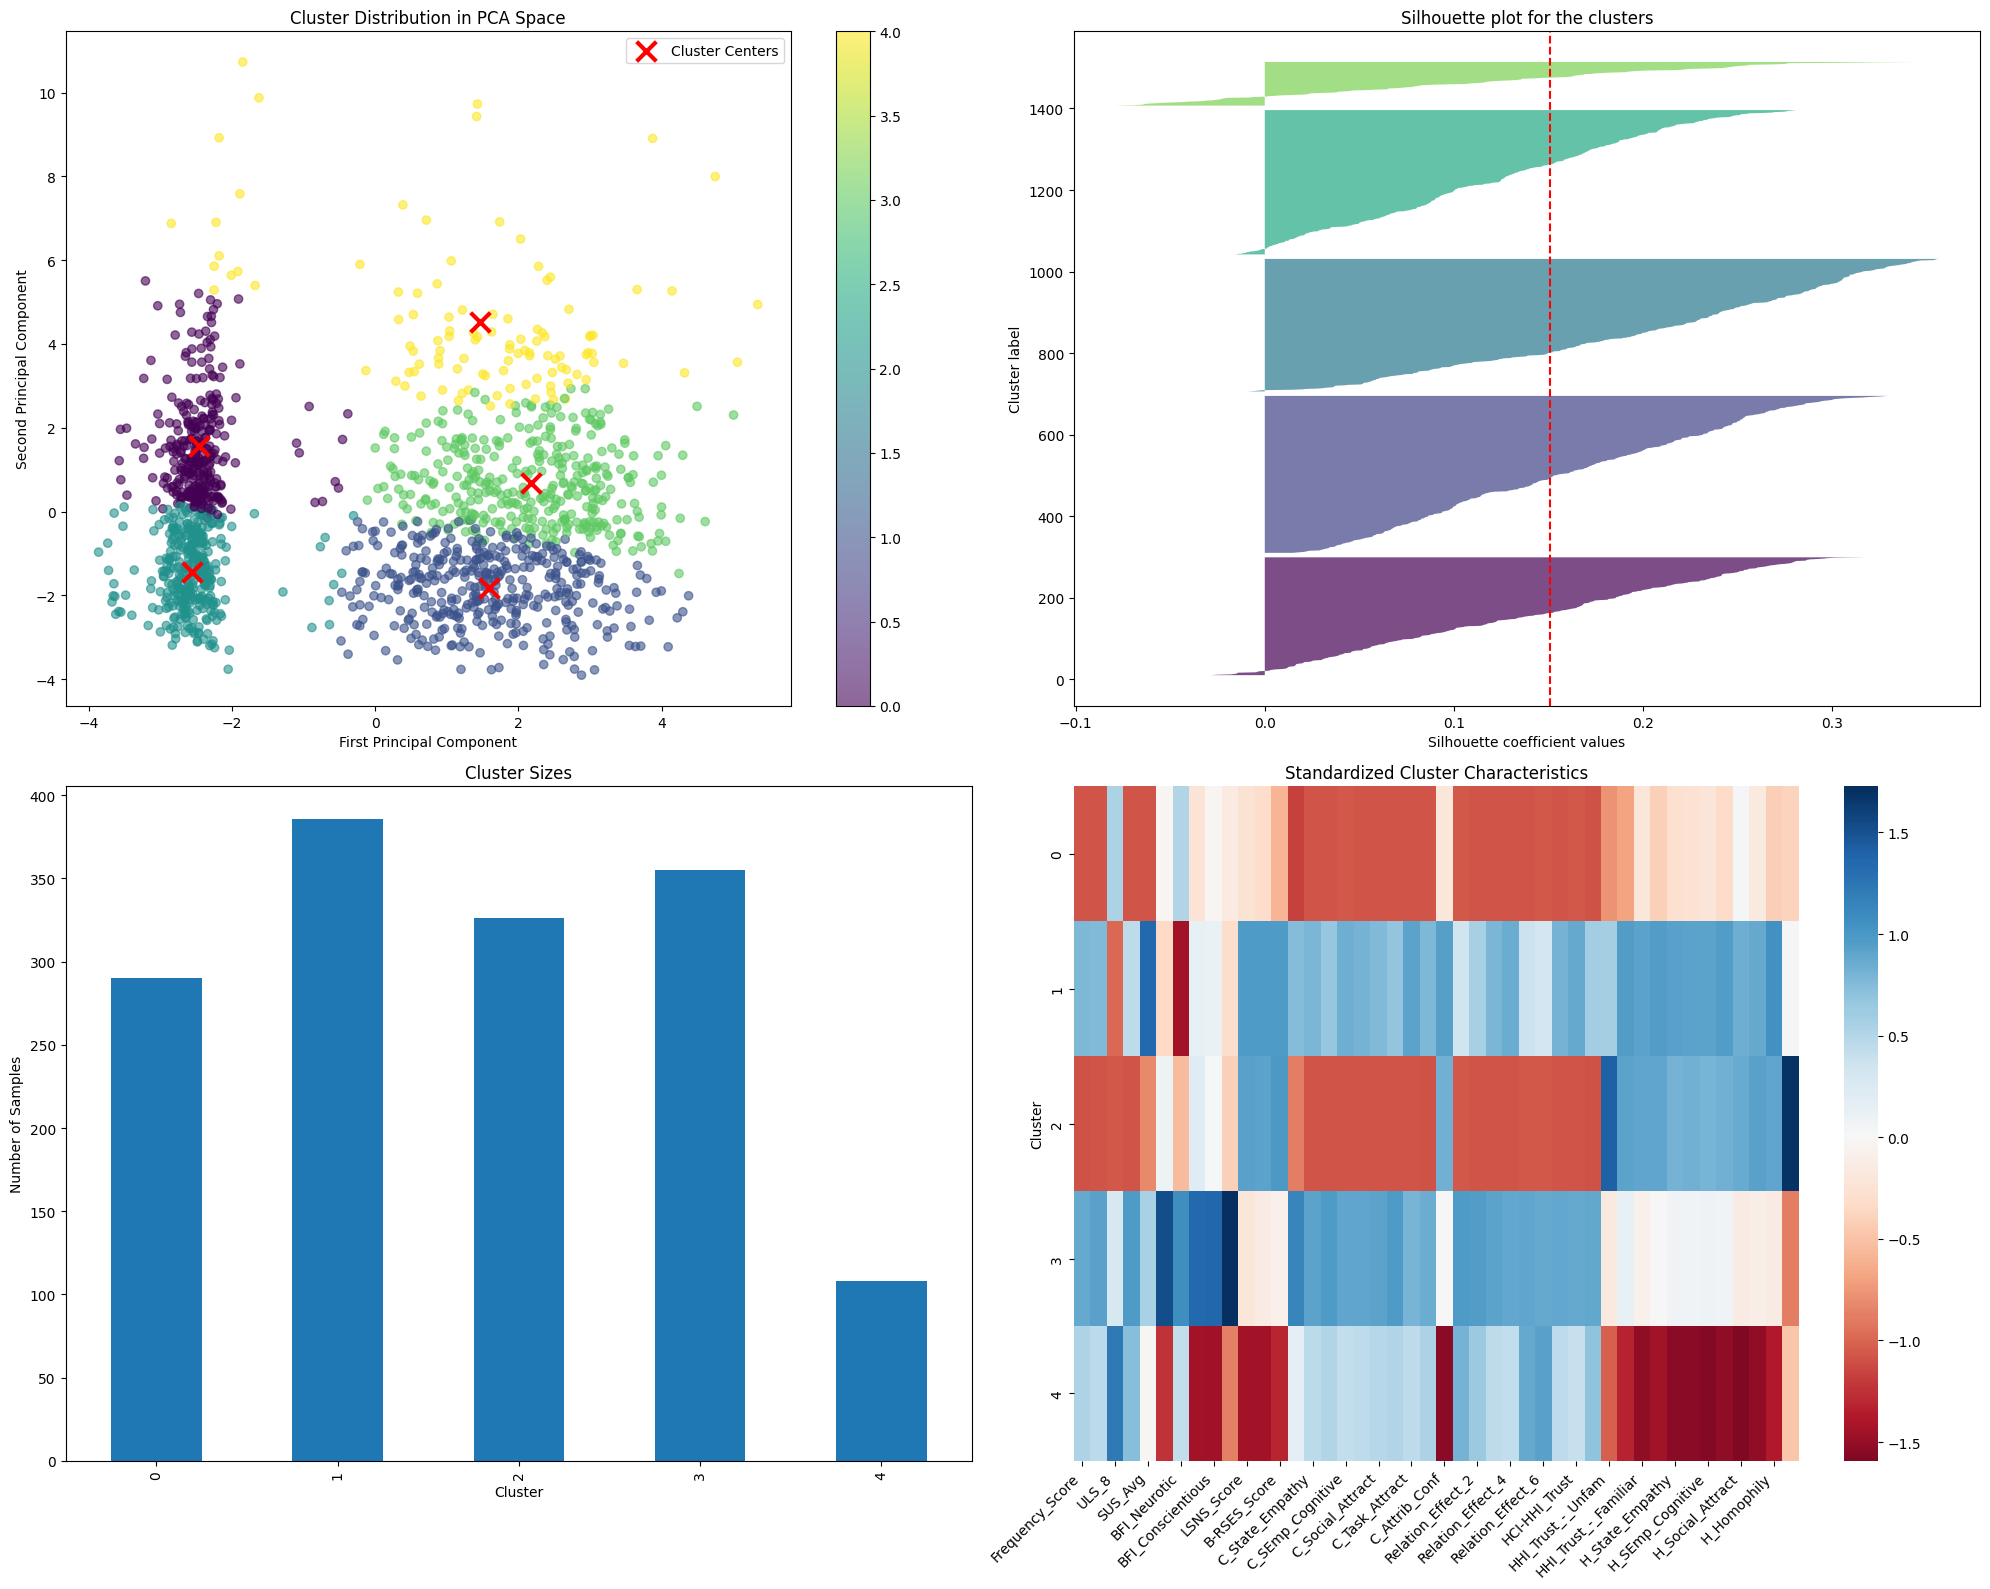

In [12]:
def optimize_clustering(df, variables, n_clusters=5, n_trials=100):
    """
    Optimizes clustering to maximize silhouette score while aiming for desired distribution
    """
    # Step 1: RobustScaler
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(df[variables])
    
    # Step 2: PCA
    # First, determine optimal number of components
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    
    # Find number of components explaining 90% variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.where(cumulative_variance >= 0.9)[0][0] + 1
    X_pca_reduced = X_pca[:, :n_components]
    
    print(f"Using {n_components} PCA components explaining {cumulative_variance[n_components-1]*100:.1f}% of variance")
    
    # Step 3: Try multiple K-means initializations
    best_silhouette = -1
    best_random_state = None
    best_labels = None
    best_kmeans = None
    
    for random_state in range(n_trials):
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
        labels = kmeans.fit_predict(X_pca_reduced)
        silhouette_avg = silhouette_score(X_pca_reduced, labels)
        
        if silhouette_avg > best_silhouette:
            best_silhouette = silhouette_avg
            best_random_state = random_state
            best_labels = labels
            best_kmeans = kmeans
    
    print(f"\nBest silhouette score: {best_silhouette:.3f}")
    print(f"Best random state: {best_random_state}")
    
    # Get cluster sizes
    cluster_sizes = np.bincount(best_labels)
    print("\nCluster sizes:", sorted(cluster_sizes, reverse=True))
    
    # Add results to dataframe
    df_clustered = df.copy()
    df_clustered['Cluster'] = best_labels
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Plot 1: First two PCA components with cluster centers
    scatter = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=best_labels, cmap='viridis', alpha=0.6)
    
    # Plot cluster centers
    centers_pca = best_kmeans.cluster_centers_
    axes[0, 0].scatter(centers_pca[:, 0], centers_pca[:, 1], 
                      c='red', marker='x', s=200, linewidths=3, 
                      label='Cluster Centers')
    
    axes[0, 0].set_xlabel('First Principal Component')
    axes[0, 0].set_ylabel('Second Principal Component')
    axes[0, 0].set_title('Cluster Distribution in PCA Space')
    axes[0, 0].legend()
    plt.colorbar(scatter, ax=axes[0, 0])
    
    # Plot 2: Silhouette plot
    from sklearn.metrics import silhouette_samples
    silhouette_vals = silhouette_samples(X_pca_reduced, best_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        cluster_silhouette_vals = silhouette_vals[best_labels == i]
        cluster_silhouette_vals.sort()
        cluster_size = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + cluster_size
        
        color = plt.cm.viridis(i / n_clusters)
        axes[0, 1].fill_betweenx(np.arange(y_lower, y_upper),
                                0, cluster_silhouette_vals,
                                facecolor=color, alpha=0.7)
        y_lower = y_upper + 10
        
    axes[0, 1].axvline(x=best_silhouette, color="red", linestyle="--")
    axes[0, 1].set_xlabel("Silhouette coefficient values")
    axes[0, 1].set_ylabel("Cluster label")
    axes[0, 1].set_title("Silhouette plot for the clusters")
    
    # Plot 3: Cluster sizes
    cluster_sizes = df_clustered['Cluster'].value_counts().sort_index()
    cluster_sizes.plot(kind='bar', ax=axes[1, 0])
    axes[1, 0].set_xlabel('Cluster')
    axes[1, 0].set_ylabel('Number of Samples')
    axes[1, 0].set_title('Cluster Sizes')
    
    # Plot 4: Feature importance heatmap
    cluster_means = df_clustered.groupby('Cluster')[variables].mean()
    cluster_means_std = (cluster_means - cluster_means.mean()) / cluster_means.std()
    sns.heatmap(cluster_means_std, cmap='RdBu', center=0, ax=axes[1, 1])
    axes[1, 1].set_title('Standardized Cluster Characteristics')
    axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    
    # Analyze feature importance for each cluster
    feature_importance = pd.DataFrame()
    for cluster in range(n_clusters):
        cluster_data = df_clustered[df_clustered['Cluster'] == cluster]
        means = cluster_data[variables].mean()
        overall_means = df_clustered[variables].mean()
        std = df_clustered[variables].std()
        z_scores = (means - overall_means) / std
        feature_importance[f'Cluster_{cluster}'] = z_scores
    
    return {
        'cluster_labels': best_labels,
        'silhouette_score': best_silhouette,
        'n_components': n_components,
        'explained_variance': cumulative_variance,
        'cluster_means': cluster_means,
        'feature_importance': feature_importance,
        'pca_components': X_pca,
        'visualization': fig,
        'df_clustered': df_clustered,
        'best_random_state': best_random_state,
        'best_kmeans': best_kmeans
    }

def analyze_clusters(results):
    """
    Provides detailed analysis of the clustering results
    """
    print("\nDetailed Cluster Analysis:")
    feature_importance = results['feature_importance']
    
    for cluster in range(5):
        print(f"\nCluster {cluster}:")
        cluster_size = (results['cluster_labels'] == cluster).sum()
        print(f"Size: {cluster_size} samples")
        
        # Get top distinguishing features
        cluster_features = feature_importance[f'Cluster_{cluster}'].sort_values(ascending=False)
        print("Top distinguishing features (with z-scores):")
        for feature, z_score in cluster_features.head().items():
            direction = "high" if z_score > 0 else "low"
            print(f"- {feature}: {direction} ({z_score:.2f})")

# Usage example:
results = optimize_clustering(data, features)
analyze_clusters(results)
plt.show()

# Correlation Analysis between pairs of variables

In [13]:
def comprehensive_analysis(df, variables):
    """
    Performs comprehensive analysis to identify optimal feature combinations
    and preprocessing steps
    """
    results = {}
    
    # 1. Correlation Analysis
    def analyze_correlations():
        corr_matrix = df[variables].corr()
        
        # Identify highly correlated variable pairs
        high_corr_pairs = []
        for i in range(len(variables)):
            for j in range(i+1, len(variables)):
                corr = corr_matrix.iloc[i, j]
                if abs(corr) > 0.7:  # Threshold for high correlation
                    high_corr_pairs.append((variables[i], variables[j], corr))
        
        return corr_matrix, high_corr_pairs
    
    # 2. Factor Analysis
    def perform_factor_analysis():
        # Standardize data first
        scaler = RobustScaler()
        X_scaled = scaler.fit_transform(df[variables])
        
        # Determine optimal number of factors
        fa = FactorAnalyzer(rotation=None, n_factors=min(len(variables), len(df)-1))
        fa.fit(X_scaled)
        
        # Get eigenvalues and variance explained
        ev, v = fa.get_eigenvalues()
        n_factors = sum(ev > 1)  # Kaiser criterion
        n_factors = max(2, min(n_factors, 5))  # At least 2, at most 5 factors
        
        # Perform factor analysis with optimal number
        fa_final = FactorAnalyzer(rotation='varimax', n_factors=n_factors)
        fa_final.fit(X_scaled)
        
        # Get factor loadings
        loadings = pd.DataFrame(
            fa_final.loadings_,
            columns=[f'Factor{i+1}' for i in range(n_factors)],
            index=variables
        )
        
        return loadings, n_factors
    
    # 3. Dimensionality Reduction Comparison
    def compare_dim_reduction():
        # Scale data
        scaler = RobustScaler()
        X_scaled = scaler.fit_transform(df[variables])
        
        # PCA
        pca = PCA()
        X_pca = pca.fit_transform(X_scaled)
        
        # t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        X_tsne = tsne.fit_transform(X_scaled)
        
        # MDS
        mds = MDS(n_components=2, random_state=42)
        X_mds = mds.fit_transform(X_scaled)
        
        return {
            'pca': {
                'explained_variance': pca.explained_variance_ratio_,
                'components': X_pca
            },
            'tsne': X_tsne,
            'mds': X_mds
        }
    
    # 4. Feature Importance Analysis
    def analyze_feature_importance():
        scaler = RobustScaler()
        X_scaled = scaler.fit_transform(df[variables])
        
        # Use PCA to create binary outcome for feature selection
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        
        # Create binary target based on first principal component
        median_val = np.median(X_pca[:, 0])
        y_binary = (X_pca[:, 0] > median_val).astype(int)
        
        # Select features
        selector = SelectKBest(score_func=f_classif, k='all')
        selector.fit(X_scaled, y_binary)
        
        # Get feature scores
        feature_scores = pd.DataFrame({
            'Feature': variables,
            'Score': selector.scores_
        }).sort_values('Score', ascending=False)
        
        return feature_scores
    
    # 5. Cluster Validation with Different Feature Subsets
    def validate_clustering(n_clusters=5):
        scaler = RobustScaler()
        X_scaled = scaler.fit_transform(df[variables])
        
        results = {}
        
        # Full set with PCA
        pca = PCA(n_components=0.9)  # 90% variance explained
        X_pca = pca.fit_transform(X_scaled)
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(X_pca)
        score_full = silhouette_score(X_pca, labels)
        results['full_set_score'] = score_full
        results['full_set_labels'] = labels
        
        # Try different feature subsets
        feature_scores = analyze_feature_importance()
        top_n_features = [5, 10, 15]
        subset_scores = {}
        
        for n in top_n_features:
            top_features = feature_scores.nlargest(n, 'Score')['Feature'].tolist()
            X_subset = X_scaled[:, [variables.index(f) for f in top_features]]
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            labels = kmeans.fit_predict(X_subset)
            score = silhouette_score(X_subset, labels)
            subset_scores[n] = {'score': score, 'features': top_features}
        
        results['subset_scores'] = subset_scores
        
        # Find best configuration
        best_n = max(subset_scores.keys(), key=lambda x: subset_scores[x]['score'])
        results['best_config'] = {
            'n_features': best_n,
            'score': subset_scores[best_n]['score'],
            'features': subset_scores[best_n]['features']
        }
        
        return results
    
    # Run all analyses
    print("Running correlation analysis...")
    results['correlations'] = analyze_correlations()
    
    print("Running factor analysis...")
    results['factor_analysis'] = perform_factor_analysis()
    
    print("Running dimensionality reduction comparison...")
    results['dim_reduction'] = compare_dim_reduction()
    
    print("Running feature importance analysis...")
    results['feature_importance'] = analyze_feature_importance()
    
    print("Running cluster validation...")
    results['cluster_validation'] = validate_clustering()
    
    return results

def print_recommendations(results):
    """
    Prints recommendations based on the analysis results
    """
    print("\nAnalysis Recommendations:")
    
    # Correlation recommendations
    print("\n1. Correlation Analysis:")
    high_corr = results['correlations'][1]
    if high_corr:
        print("Consider removing one variable from each highly correlated pair:")
        for var1, var2, corr in high_corr:
            print(f"- {var1} and {var2} (correlation: {corr:.2f})")
    
    # Factor analysis recommendations
    print("\n2. Factor Analysis:")
    loadings, n_factors = results['factor_analysis']
    print(f"- Consider using {n_factors} factors instead of individual variables")
    print("Top loadings for each factor:")
    for factor in loadings.columns:
        top_vars = loadings[factor].abs().nlargest(3)
        print(f"\n{factor}:")
        for var, loading in top_vars.items():
            print(f"  - {var}: {loading:.2f}")
    
    # Feature importance recommendations
    print("\n3. Feature Importance:")
    top_features = results['feature_importance'].nlargest(5, 'Score')
    print("Top 5 most important features:")
    for _, row in top_features.iterrows():
        print(f"- {row['Feature']} (score: {row['Score']:.2f})")
    
    # Clustering recommendations
    print("\n4. Clustering Recommendations:")
    cv = results['cluster_validation']
    print(f"Full feature set silhouette score: {cv['full_set_score']:.3f}")
    print("\nFeature subset performance:")
    for n, data in cv['subset_scores'].items():
        print(f"- Top {n} features: {data['score']:.3f}")
    
    print(f"\nBest configuration:")
    best = cv['best_config']
    print(f"- Use top {best['n_features']} features (silhouette score: {best['score']:.3f})")
    print("- Selected features:", ", ".join(best['features']))

# Usage example:
results = comprehensive_analysis(data, features)
print_recommendations(results)

Running correlation analysis...
Running factor analysis...
Running dimensionality reduction comparison...
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
Running feature importance analysis...
Running cluster validation...

Analysis Recommendations:

1. Correlation Analysis:
Consider removing one variable from each highly correlated pair:
- Frequency_Score and Session_Length_Score (correlation: 0.82)
- Frequency_Score and GPIUS2 (correlation: 0.82)
- Frequency_Score and C_State_Empathy (correlation: 0.87)
- Frequency_Score and C_SEmp_Affective (correlation: 0.80)
- Frequency_Score and C_SEmp_Cognitive (correlation: 0.87)
- Frequency_Score and C_SEmp_A

# Composite Scores for factors

We group variables into 5 factors and evaluate 

In [14]:
def comprehensive_analysis(df, variables):
    """
    Performs comprehensive analysis to identify optimal feature combinations
    and preprocessing steps
    """
    results = {}
    
    # 1. Correlation Analysis
    def analyze_correlations():
        corr_matrix = df[variables].corr()
        
        # Identify highly correlated variable pairs
        high_corr_pairs = []
        for i in range(len(variables)):
            for j in range(i+1, len(variables)):
                corr = corr_matrix.iloc[i, j]
                if abs(corr) > 0.7:  # Threshold for high correlation
                    high_corr_pairs.append((variables[i], variables[j], corr))
        
        return corr_matrix, high_corr_pairs
    
    # 2. Factor Analysis
    def perform_factor_analysis():
        # Standardize data first
        scaler = RobustScaler()
        X_scaled = scaler.fit_transform(df[variables])
        
        # Determine optimal number of factors
        fa = FactorAnalyzer(rotation=None, n_factors=min(len(variables), len(df)-1))
        fa.fit(X_scaled)
        
        # Get eigenvalues and variance explained
        ev, v = fa.get_eigenvalues()
        n_factors = sum(ev > 1)  # Kaiser criterion
        n_factors = max(2, min(n_factors, 5))  # At least 2, at most 5 factors
        
        # Perform factor analysis with optimal number
        fa_final = FactorAnalyzer(rotation='varimax', n_factors=n_factors)
        fa_final.fit(X_scaled)
        
        # Get factor loadings
        loadings = pd.DataFrame(
            fa_final.loadings_,
            columns=[f'Factor{i+1}' for i in range(n_factors)],
            index=variables
        )
        
        return loadings, n_factors
    
    # 3. Dimensionality Reduction Comparison
    def compare_dim_reduction():
        # Scale data
        scaler = RobustScaler()
        X_scaled = scaler.fit_transform(df[variables])
        
        # PCA
        pca = PCA()
        X_pca = pca.fit_transform(X_scaled)
        
        # t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        X_tsne = tsne.fit_transform(X_scaled)
        
        # MDS
        mds = MDS(n_components=2, random_state=42)
        X_mds = mds.fit_transform(X_scaled)
        
        return {
            'pca': {
                'explained_variance': pca.explained_variance_ratio_,
                'components': X_pca
            },
            'tsne': X_tsne,
            'mds': X_mds
        }
    
    # 4. Feature Importance Analysis
    def analyze_feature_importance():
        scaler = RobustScaler()
        X_scaled = scaler.fit_transform(df[variables])
        
        # Use PCA to create binary outcome for feature selection
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        
        # Create binary target based on first principal component
        median_val = np.median(X_pca[:, 0])
        y_binary = (X_pca[:, 0] > median_val).astype(int)
        
        # Select features
        selector = SelectKBest(score_func=f_classif, k='all')
        selector.fit(X_scaled, y_binary)
        
        # Get feature scores
        feature_scores = pd.DataFrame({
            'Feature': variables,
            'Score': selector.scores_
        }).sort_values('Score', ascending=False)
        
        return feature_scores
    
    # 5. Cluster Validation with Different Feature Subsets
    def validate_clustering(n_clusters=5):
        scaler = RobustScaler()
        X_scaled = scaler.fit_transform(df[variables])
        
        results = {}
        
        # Full set with PCA
        pca = PCA(n_components=0.9)  # 90% variance explained
        X_pca = pca.fit_transform(X_scaled)
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(X_pca)
        score_full = silhouette_score(X_pca, labels)
        results['full_set_score'] = score_full
        results['full_set_labels'] = labels
        
        # Try different feature subsets
        feature_scores = analyze_feature_importance()
        top_n_features = [5, 10, 15]
        subset_scores = {}
        
        for n in top_n_features:
            top_features = feature_scores.nlargest(n, 'Score')['Feature'].tolist()
            X_subset = X_scaled[:, [variables.index(f) for f in top_features]]
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            labels = kmeans.fit_predict(X_subset)
            score = silhouette_score(X_subset, labels)
            subset_scores[n] = {'score': score, 'features': top_features}
        
        results['subset_scores'] = subset_scores
        
        # Find best configuration
        best_n = max(subset_scores.keys(), key=lambda x: subset_scores[x]['score'])
        results['best_config'] = {
            'n_features': best_n,
            'score': subset_scores[best_n]['score'],
            'features': subset_scores[best_n]['features']
        }
        
        return results
    
    # Run all analyses
    print("Running correlation analysis...")
    results['correlations'] = analyze_correlations()
    
    print("Running factor analysis...")
    results['factor_analysis'] = perform_factor_analysis()
    
    print("Running dimensionality reduction comparison...")
    results['dim_reduction'] = compare_dim_reduction()
    
    print("Running feature importance analysis...")
    results['feature_importance'] = analyze_feature_importance()
    
    print("Running cluster validation...")
    results['cluster_validation'] = validate_clustering()
    
    return results

def print_recommendations(results):
    """
    Prints recommendations based on the analysis results
    """
    print("\nAnalysis Recommendations:")
    
    # Correlation recommendations
    print("\n1. Correlation Analysis:")
    high_corr = results['correlations'][1]
    if high_corr:
        print("Consider removing one variable from each highly correlated pair:")
        for var1, var2, corr in high_corr:
            print(f"- {var1} and {var2} (correlation: {corr:.2f})")
    
    # Factor analysis recommendations
    print("\n2. Factor Analysis:")
    loadings, n_factors = results['factor_analysis']
    print(f"- Consider using {n_factors} factors instead of individual variables")
    print("Top loadings for each factor:")
    for factor in loadings.columns:
        top_vars = loadings[factor].abs().nlargest(3)
        print(f"\n{factor}:")
        for var, loading in top_vars.items():
            print(f"  - {var}: {loading:.2f}")
    
    # Feature importance recommendations
    print("\n3. Feature Importance:")
    top_features = results['feature_importance'].nlargest(5, 'Score')
    print("Top 5 most important features:")
    for _, row in top_features.iterrows():
        print(f"- {row['Feature']} (score: {row['Score']:.2f})")
    
    # Clustering recommendations
    print("\n4. Clustering Recommendations:")
    cv = results['cluster_validation']
    print(f"Full feature set silhouette score: {cv['full_set_score']:.3f}")
    print("\nFeature subset performance:")
    for n, data in cv['subset_scores'].items():
        print(f"- Top {n} features: {data['score']:.3f}")
    
    print(f"\nBest configuration:")
    best = cv['best_config']
    print(f"- Use top {best['n_features']} features (silhouette score: {best['score']:.3f})")
    print("- Selected features:", ", ".join(best['features']))

# Usage example:
results = comprehensive_analysis(data, features)
print_recommendations(results)

Running correlation analysis...
Running factor analysis...
Running dimensionality reduction comparison...
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
Running feature importance analysis...
Running cluster validation...

Analysis Recommendations:

1. Correlation Analysis:
Consider removing one variable from each highly correlated pair:
- Frequency_Score and Session_Length_Score (correlation: 0.82)
- Frequency_Score and GPIUS2 (correlation: 0.82)
- Frequency_Score and C_State_Empathy (correlation: 0.87)
- Frequency_Score and C_SEmp_Affective (correlation: 0.80)
- Frequency_Score and C_SEmp_Cognitive (correlation: 0.87)
- Frequency_Score and C_SEmp_A

In [15]:
results

{'correlations': (                           Frequency_Score  Session_Length_Score     ULS_8  \
  Frequency_Score                   1.000000              0.819063  0.033226   
  Session_Length_Score              0.819063              1.000000  0.043953   
  ULS_8                             0.033226              0.043953  1.000000   
  GPIUS2                            0.823639              0.756734  0.162611   
  SUS_Avg                           0.381324              0.351179  0.036801   
  BFI_Extraversion                 -0.001859              0.022719 -0.044487   
  BFI_Neurotic                     -0.028221             -0.009645  0.173370   
  BFI_Agreeableness                 0.025530              0.043239 -0.064464   
  BFI_Conscientious                 0.025346              0.042791 -0.046493   
  BFI_Openness                      0.035474              0.055396  0.023227   
  LSNS_Score                       -0.038388             -0.045420 -0.495578   
  MSPSS_Score           

In [22]:
results['df_clustered'][results['Survey_Number'] == 3]

,Unnamed:_0.1,Unnamed:_0,index,StartDate,EndDate,Status_x,Progress,Duration_(in_seconds),Finished,RecordedDate,...,Which_Chatbots_S_3_TEXT,Chatbot_Frequency_S,Chatbot_Frequency_S_8_TEXT,Session_Length_S,Usage_Timeframe_S,Chatbot_Device_S,Chatbot_Device_S_4_TEXT,Interview_Interest,s1_cluster,Cluster
0,0,0,2,2024-06-10 16:25:22,2024-06-10 16:36:39,IP Address,100,677,True,2024-06-10 16:36:40,...,0,0,0.0,0,0,0,0.0,0,2.0,0
1,1,1,3,2024-06-10 16:22:15,2024-06-10 16:37:20,IP Address,100,905,True,2024-06-10 16:37:21,...,0,0,0.0,0,0,0,0.0,0,6.0,4
2,2,2,4,2024-06-10 16:26:47,2024-06-10 16:39:38,IP Address,100,770,True,2024-06-10 16:39:38,...,0,0,0.0,0,0,0,0.0,0,1.0,0
3,3,3,5,2024-06-10 16:22:16,2024-06-10 16:39:57,IP Address,100,1060,True,2024-06-10 16:39:57,...,0,0,0.0,0,0,0,0.0,0,2.0,4
4,4,4,6,2024-06-10 16:25:01,2024-06-10 16:40:11,IP Address,100,909,True,2024-06-10 16:40:11,...,0,0,0.0,0,0,0,0.0,0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,1460,352,373,2024-11-07 08:43:14,2024-11-07 08:57:44,IP Address,100,869,True,2024-11-07 08:57:45,...,0,Once a month or less,0.0,<15 min,a few weeks,"Computer,Smartphone",0.0,No,3.0,3
1461,1461,353,375,2024-11-07 14:39:52,2024-11-07 15:09:35,IP Address,100,1782,True,2024-11-07 15:09:36,...,0,0,0.0,0,0,0,0.0,Yes,0.0,1
1462,1462,354,376,2024-11-08 07:46:39,2024-11-08 07:53:48,IP Address,100,428,True,2024-11-08 07:53:48,...,0,0,0.0,0,0,0,0.0,No,2.0,2
1463,1463,355,377,2024-11-08 16:14:44,2024-11-08 16:27:05,IP Address,100,740,True,2024-11-08 16:27:06,...,0,0,0.0,0,0,0,0.0,Yes,0.0,2


In [ ]:
def create_heatmap(cluster_data, features, target_variables):
    # Calculate mean values for all features and target variables
    cluster_means = cluster_data.groupby('Cluster')[features + target_variables].mean()

    plt.figure(figsize=(10, 6))
    
    sns.heatmap(cluster_means, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Cluster Characteristics Heatmap - Standardized Values')
    plt.ylabel('Cluster')
    plt.xlabel('Variables')
    plt.tight_layout()
    plt.savefig("/work/Output Figures/ClusterHeatmap.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    
    return cluster_means

In [ ]:
def create_detailed_heatmap(cluster_data, features, target_variables, transpose=False):
    # Calculate mean values for all features and target variables
    cluster_means = cluster_data.groupby('Cluster')[features + target_variables].mean()
    cluster_means_viz = cluster_means.copy()
    if transpose:
        cluster_means_viz = cluster_means_viz.transpose()
        plt.figure(figsize=(len(cluster_means.columns) * 0.3, 16))
    else:
        plt.figure(figsize=(20, len(cluster_means.columns) * 0.2))
    # Create a heatmap
    
    sns.heatmap(cluster_means_viz, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Detailed Cluster Characteristics Heatmap - Standardized Values')
    plt.ylabel('Variables' if transpose else 'Cluster')
    plt.xlabel('Cluster' if transpose else 'Variables')
    plt.tight_layout()
    plt.savefig("/work/Output Figures/DetailedClusterHeatmap.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    
    return cluster_means

def create_detailed_heatmap_std(cluster_data, features, target_variables, transpose=False):
    # Combine features and target variables
    all_variables = features + target_variables
    
    # Calculate mean values for all variables
    cluster_means = cluster_data.groupby('Cluster')[all_variables].mean()
    
    # Standardize the data
    scaler = StandardScaler()
    all_data_std = scaler.fit_transform(cluster_data[all_variables])

    # Calculate standardized means for each cluster
    cluster_means_std = pd.DataFrame(
        index=cluster_means.index,
        columns=cluster_means.columns,
        data=scaler.transform(cluster_means)
    )
    
    # Prepare the data for visualization
    cluster_means_viz = cluster_means.copy()
    if transpose:
        cluster_means_viz = cluster_means_viz.transpose()
        cluster_means_std = cluster_means_std.transpose()
        plt.figure(figsize=(len(cluster_means.columns) * 0.3, len(all_variables) * 0.4))
    else:
        plt.figure(figsize=(len(all_variables) * 0.4, len(cluster_means.columns) * 0.5))
    
    # Create a heatmap
    sns.heatmap(cluster_means_std, annot=cluster_means_viz, fmt='.2f', 
                cmap='coolwarm', center=0, cbar_kws={'label': 'Standard Deviations'})
    
    plt.title('Detailed Cluster Characteristics Heatmap - Original Scale Values')
    plt.ylabel('Variables' if transpose else 'Cluster')
    plt.xlabel('Cluster' if transpose else 'Variables')
    plt.tight_layout()
    plt.savefig("/work/Output Figures/DetailedClusterHeatmap_std.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    
    return cluster_means

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from factor_analyzer import FactorAnalyzer
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt



def prepare_analysis(df):
    """
    Prepares data for both clustering and linear mixed effects modeling
    with improved error handling
    """
    # 1. Selected features for clustering (using the ones that gave best silhouette score)
    selected_features = [
        'HCI-HHI_Trust',
        'C_State_Empathy',
        'HCI-HHI_Expectation',
        'C_SEmp_Associative',
        'C_SEmp_Cognitive'
    ]
    
    # 2. Create composite scores based on correlation groups
    composite_scores = {
        'chatbot_interaction': [
            'C_State_Empathy', 'C_SEmp_Affective', 'C_SEmp_Cognitive',
            'C_SEmp_Associative', 'C_Social_Attract', 'C_Task_Attract', 'C_Homophily'
        ],
        'human_interaction': [
            'H_State_Empathy', 'H_SEmp_Affective', 'H_SEmp_Cognitive', 
            'H_SEmp_Associative'
        ],
        'personality': [
            'BFI_Extraversion', 'BFI_Neurotic', 'BFI_Agreeableness',
            'BFI_Conscientious', 'BFI_Openness'
        ],
        'usage': ['Frequency_Score', 'Session_Length_Score'],
        'relation_effects': [
            'Relation_Effect_1', 'Relation_Effect_2', 'Relation_Effect_3',
            'Relation_Effect_4', 'Relation_Effect_5', 'Relation_Effect_6'
        ],
        'hci_hhi': [
            'HCI-HHI_Expectation', 'HCI-HHI_Trust', 'HCI-HHI_Substitution'
        ]
    }
    
    # Create composite scores
    df_composite = df.copy()
    print("Creating composite scores...")
    for composite_name, variables in composite_scores.items():
        # Check if all variables exist in the dataframe
        existing_vars = [var for var in variables if var in df.columns]
        if existing_vars:
            df_composite[composite_name] = df[existing_vars].mean(axis=1)
            print(f"Created {composite_name} from {len(existing_vars)} variables")
        else:
            print(f"Warning: No variables found for {composite_name}")
    
    # 3. Perform clustering on selected features
    print("\nPerforming clustering...")
    # Check if all selected features exist in the dataframe
    existing_features = [f for f in selected_features if f in df.columns]
    if not existing_features:
        raise ValueError("None of the selected features found in the dataframe")
    
    # Scale the features
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(df[existing_features])
    
    # Perform clustering
    kmeans = KMeans(n_clusters=5, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    silhouette = silhouette_score(X_scaled, clusters)
    print(f"Clustering complete. Silhouette score: {silhouette:.3f}")
    
    # 4. Factor Analysis
    print("\nPerforming factor analysis...")
    # Prepare variables for factor analysis
    factor_vars = []
    for var_list in composite_scores.values():
        factor_vars.extend([var for var in var_list if var in df.columns])
    
    # Remove duplicates while preserving order
    factor_vars = list(dict.fromkeys(factor_vars))
    
    # Scale data for factor analysis
    X_scaled_fa = RobustScaler().fit_transform(df[factor_vars])
    
    # Try factor analysis with different numbers of factors
    n_factors = min(5, len(factor_vars)-1)  # Ensure we don't exceed number of variables
    fa = FactorAnalyzer(rotation='varimax', n_factors=n_factors)
    fa.fit(X_scaled_fa)
    
    # Generate factor scores
    factor_scores = pd.DataFrame(
        fa.transform(X_scaled_fa),
        columns=[f'factor_{i+1}' for i in range(n_factors)]
    )
    print(f"Factor analysis complete with {n_factors} factors")
    
    # Add results to dataframe
    df_composite['cluster'] = clusters
    for col in factor_scores.columns:
        df_composite[col] = factor_scores[col]
    
    # Create visualizations
    print("\nCreating visualizations...")
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Plot 1: Cluster sizes
    cluster_sizes = pd.Series(clusters).value_counts().sort_index()
    sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, ax=axes[0, 0])
    axes[0, 0].set_title(f'Cluster Sizes\nSilhouette Score: {silhouette:.3f}')
    
    # Plot 2: Cluster characteristics
    cluster_means = df[existing_features].groupby(clusters).mean()
    sns.heatmap(cluster_means, cmap='RdBu', center=0, ax=axes[0, 1])
    axes[0, 1].set_title('Cluster Characteristics')
    
    # Plot 3: Composite score distributions
    composite_cols = [col for col in composite_scores.keys() if col in df_composite.columns]
    if composite_cols:
        composite_melted = df_composite[composite_cols].melt()
        sns.boxplot(x='variable', y='value', data=composite_melted, ax=axes[1, 0])
        axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45)
        axes[1, 0].set_title('Composite Score Distributions')
    
    # Plot 4: Factor score distributions
    factor_cols = [col for col in df_composite if 'factor_' in col]
    if factor_cols:
        factor_melted = df_composite[factor_cols].melt()
        sns.boxplot(x='variable', y='value', data=factor_melted, ax=axes[1, 1])
        axes[1, 1].set_title('Factor Score Distributions')
    
    plt.tight_layout()
    print("Visualizations complete")
    
    return {
        'df_composite': df_composite,
        'clusters': clusters,
        'silhouette_score': silhouette,
        'cluster_centers': kmeans.cluster_centers_,
        'factor_loadings': pd.DataFrame(
            fa.loadings_,
            columns=[f'Factor{i+1}' for i in range(n_factors)],
            index=factor_vars
        ),
        'visualizations': fig,
        'selected_features': existing_features,
        'composite_scores': composite_scores
    }

def print_analysis_summary(results):
    """
    Prints a summary of the analysis results
    """
    print("\nAnalysis Summary:")
    print("================")
    
    print("\nClustering Results:")
    print(f"Silhouette Score: {results['silhouette_score']:.3f}")
    print("\nCluster Sizes:")
    cluster_sizes = pd.Series(results['clusters']).value_counts().sort_index()
    print(cluster_sizes)
    
    print("\nFactor Loadings:")
    print(results['factor_loadings'].round(3))
    
    print("\nAvailable Features:")
    print("- Selected features:", results['selected_features'])
    print("\nComposite Scores:")
    for name, vars in results['composite_scores'].items():
        if name in results['df_composite'].columns:
            print(f"- {name}: {len(vars)} variables")

# Usage example:
results = prepare_analysis(data)
df_composite = results["df_composite"]
print_analysis_summary(results)
plt.show()